# Argument Segmentation Model


In [1]:
from pathlib import Path
try:
    BASE_PATH = str(Path(__file__, "..", "..", "..").resolve())
    import sys
except NameError:
    import sys
    BASE_PATH = str(Path("..", "..").resolve())

if __name__ == "__main__":
    if BASE_PATH not in sys.path:
        sys.path.insert(0, BASE_PATH)


In [2]:
from tensorflow import keras
from keras import layers
from pathlib import Path
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import json
from pos_tagger.pos_tagger import NLTKPOSTagger, SpacyPOSTagger


## Initial parameters

In [6]:

# INFO_TAG = "persuasive_essays_paragraph"
# INFO_TAG = "persuasive_essays_paragraph_all_linked"
# INFO_TAG = "cdcp"
# INFO_TAG = "drinventor"
INFO_TAG = "abstrct"


# LANGUAGE = "english"
LANGUAGE = "spanish"
if LANGUAGE == "english":
    GLOVE_DIR = Path(BASE_PATH, "data/", 'glove.840B.300d.txt')
elif LANGUAGE == "spanish":
    GLOVE_DIR = Path(BASE_PATH, "data/", 'glove-sbwc.i25.vec')
else:
    raise Exception(f"Language {LANGUAGE} not supported")

SOURCE_DATADIR = Path(BASE_PATH, f"data/projection/{INFO_TAG}").resolve()
DATA_DIR = Path(BASE_PATH, f"data/segmenter_corpus/{INFO_TAG}").resolve()
TO_PROCESS_DATADIR = Path(BASE_PATH, f"data/to_process").resolve()
PROCESSED_DATADIR = Path(BASE_PATH, f"data/segmenter_processed/{INFO_TAG}").resolve()

params = {
    # POS Tagger
    "pos_tagger": "nltk", # Can be NLTK or Spacy
    
    
    # POS Hyperparameters
    'with_pos': True,
    'pos_units': 5,
    'pos_activation': 'relu',
 
    # Model Hyperparameters
    'dim': 300,
    'dropout': 0.5,
    'epochs': 120,
    'batch_size': 20,
    'lstm_size': 200,
    'optimizer': 'adam',
#     'metrics': ['acc'], # Problems with the boolean mask
    'trainable_word_emeddings': False,
    'regularization': "l2",
    
    # ResNet
    'with_resnet': True,
    
    # Layer Normalization
    'with_layer_normalization': True,
    
    # Early Stopping
    'with_early_stopping': True,
    'early_stopping_monitor': 'val_crf_loss',
    'early_stopping_patience': 10,
    'restore_best_weights': True,
    
    # CNN Char Hyperparameters
    'with_cnn': True,
    'dim_chars': 50,
    'filters': 30,
    'kernel_size': 3,
    
    # LSTM Char Hyperparameters
    'with_lstm': True,
    'dim_chars_lstm': 25,
    
    # Dense Layer Hyperparameters
    'with_dn': True,
    'dense_units': 100,
    'dense_activation': "relu",
    
    # Vectorizer Hyperparameters
    'standardize': "lower", 
    'split': "whitespace",
    'max_seq_size': 580,
    
    # Corpus info
#     'corpus_type': "sentence",
    'corpus_type': "paragraph", 
    'language': LANGUAGE,
#     'meta_tags_level': 0, # BIOES 
    'meta_tags_level': 1, # BIOES-MetaTag
    'words_path': str(Path(DATA_DIR, 'vocab.words.txt')),
    'chars_path': str(Path(DATA_DIR, 'vocab.chars.txt')),
    'tags_path': str(Path(DATA_DIR, 'vocab.tags.txt')),
    'pos_path': str(Path(DATA_DIR, 'vocab.pos.txt')),
    'sequences_path': (str(Path(DATA_DIR, 'train.words.txt')), str(Path(DATA_DIR, 'testa.words.txt')), str(Path(DATA_DIR, 'testb.words.txt'))),
    'labels_path': (str(Path(DATA_DIR, 'train.tags.txt')), str(Path(DATA_DIR, 'testa.tags.txt')), str(Path(DATA_DIR, 'testb.tags.txt'))),
    'pos_labels_path': (str(Path(DATA_DIR, 'train.pos.txt')), str(Path(DATA_DIR, 'testa.pos.txt')), str(Path(DATA_DIR, 'testb.pos.txt'))),
    'char_vectorization_path': str(Path(DATA_DIR, 'char_vectorization.npz')),
    'glove_raw_path': str(Path(GLOVE_DIR)),

    # Data info
    'source_data_path': str(Path(SOURCE_DATADIR)), # Directory with conll annotated texts
    'data_path': str(Path(DATA_DIR)), # Directory with the segmenter corpus
    'to_process_data_path': str(Path(TO_PROCESS_DATADIR)), # Directory with text to be processed
    'processed_data_path': str(Path(PROCESSED_DATADIR)), # Directory to save the processed data
}

MODEL_NAME = params['corpus_type'] + \
    ("_pos" if params['with_pos'] else "") + \
    "_model" + \
    ("_cnn" if params['with_cnn'] else "") + \
    ("_lstm" if params['with_lstm'] else "") + \
    "_blstm" + \
    ("_resnet" if params['with_resnet'] else "") + \
    ("_norm" if params['with_layer_normalization'] else "") + \
    ("_dn" if params['with_dn'] else "") + \
    (f"_{params['standardize']}" if params['standardize'] else "") + \
    "_crf"

params.update({
    'model_name': MODEL_NAME,
    
    # Model serialization info
    'model_path': str(Path(DATA_DIR, MODEL_NAME)),
    'full_model_path': str(Path(DATA_DIR, MODEL_NAME)),
    'model_histories_path': str(Path(DATA_DIR, MODEL_NAME)),
    'checkpoint_path': str(Path(Path(DATA_DIR, MODEL_NAME, "checkpoints"))),
    'glove_path': str(Path(DATA_DIR, 'glove.npz' if not params['standardize'] else f'glove_{params["standardize"]}.npz')),
})

# Serialize Parameters
save_params = True
load_params = False

if load_params:
    params = json.load(Path(params['model_path'], "params.json").open("r"))
elif save_params:
    Path(params['model_path']).mkdir(exist_ok=True)
    json.dump(params, Path(params['model_path'], "params.json").open("w"))

# Non serializable switch
if params['pos_tagger'] in ['nltk', 'spacy']:
    params.update({
        # POS Tagger
        'pos_tagger': NLTKPOSTagger() if params['pos_tagger'] == "nltk" else (SpacyPOSTagger() if params['pos_tagger'] == "spacy" else None),
    })
else:
    raise Exception()

## Prepare Corpus

Creates the corpus for the model based on the parameters

In [4]:
# Prepare model corpus
from segmenter.models.segmenter_exporter import export_directory, export_files

def create_segmenter_corpus(params: dict):
    corpus_type = params['corpus_type']
    if corpus_type == "paragraph":
        export_directory(Path(params['source_data_path']), 
                         Path(params['data_path']), 
                         language=params['language'],
                         meta_tags_level=params['meta_tags_level'])
    elif corpus_type == "sentence":
        # For sentences
        export_files(Path(params['source_data_path']), 
                     Path(params['data_path']), 
                     language=params['language'],
                     meta_tags_level=params['meta_tags_level'])
    else:
        print(f"WARNING: {corpus_type} is an invalid corpus_type")

# create_segmenter_corpus(params)


## Datasets and Vectorizers

Add the datasets and vectorizers. Also other values are computed such as char amount, word amount, etc.

In [7]:
def add_datasets(params: dict):
    
    def configure_dataset(dataset):
        return dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    def get_length_dataset(dataset):
        return int(dataset.reduce(initial_state=0, reduce_func=lambda x,y: x + 1))
    
    # Creating datasets
    
    train_sequences_dataset = configure_dataset(tf.data.TextLineDataset([params['sequences_path'][0]]))
    testa_sequences_dataset = configure_dataset(tf.data.TextLineDataset([params['sequences_path'][1]]))
    testb_sequences_dataset = configure_dataset(tf.data.TextLineDataset([params['sequences_path'][2]]))
    
    train_labels_dataset = configure_dataset(tf.data.TextLineDataset([params['labels_path'][0]]))
    testa_labels_dataset = configure_dataset(tf.data.TextLineDataset([params['labels_path'][1]]))
    testb_labels_dataset = configure_dataset(tf.data.TextLineDataset([params['labels_path'][2]]))
    
    train_pos_labels_dataset = configure_dataset(tf.data.TextLineDataset([params['pos_labels_path'][0]]))
    testa_pos_labels_dataset = configure_dataset(tf.data.TextLineDataset([params['pos_labels_path'][1]]))
    testb_pos_labels_dataset = configure_dataset(tf.data.TextLineDataset([params['pos_labels_path'][2]]))
    
    if params['with_pos']:
        train_sequences_dataset = tf.data.Dataset.zip((train_sequences_dataset, train_pos_labels_dataset))
        testa_sequences_dataset = tf.data.Dataset.zip((testa_sequences_dataset, testa_pos_labels_dataset))
        testb_sequences_dataset = tf.data.Dataset.zip((testb_sequences_dataset, testb_pos_labels_dataset))
    
    chars_dataset = configure_dataset(tf.data.TextLineDataset([params['chars_path']]))
    words_dataset = configure_dataset(tf.data.TextLineDataset([params['words_path']]))
    tags_dataset = configure_dataset(tf.data.TextLineDataset([params['tags_path']]))
    pos_dataset = configure_dataset(tf.data.TextLineDataset([params['pos_path']]))
    
    # Saving datasets
    
    params["train_sequences"] = train_sequences_dataset
    params["testa_sequences"] = testa_sequences_dataset
    params["testb_sequences"] = testb_sequences_dataset
    
    params["train_labels"] = train_labels_dataset
    params["testa_labels"] = testa_labels_dataset
    params["testb_labels"] = testb_labels_dataset
    
    params["train_pos_labels"] = train_pos_labels_dataset
    params["testa_pos_labels"] = testa_pos_labels_dataset
    params["testb_pos_labels"] = testb_pos_labels_dataset
    
    params["chars"] = chars_dataset
    params["words"] = words_dataset
    params["tags"] = tags_dataset
    params["pos"] = pos_dataset
    
    # Computing dataset information
    
    params['tag_amount'] = get_length_dataset(tags_dataset)
    params['char_amount'] = get_length_dataset(chars_dataset)
    params['pos_amount'] = get_length_dataset(pos_dataset)
    params['max_word_size'] = int(words_dataset.reduce(initial_state=0, reduce_func=lambda x,y: tf.maximum(x, tf.strings.length(y))))
    max_seq_size = int(train_labels_dataset.reduce(initial_state=tf.constant([0]), reduce_func=lambda x,y: tf.maximum(x, tf.shape(tf.strings.split(y, sep=" "))))[0])
    params['max_seq_size'] = min(max_seq_size, params['max_seq_size'])
    # Creating sequence vectorizer
    
    sequence_vectorizer = layers.TextVectorization(
        output_mode = "int",
#         max_tokens = params['word_amount'] + 2, # Plus PAD and UNK
        output_sequence_length = params['max_seq_size'],
        standardize = params['standardize'],
        split = params['split']
    )
    
    sequence_vectorizer.adapt(train_sequences_dataset)
    params['sequence_vectorizer'] = sequence_vectorizer
    
    # Creating tag vectorizer
    
    tag_vectorizer = layers.TextVectorization(
        output_mode = "int",
        max_tokens = params['tag_amount'] + 2, # Plus PAD and UNK
        output_sequence_length = params['max_seq_size'],
        standardize = None,
        split = "whitespace"
    )
    
    tag_vectorizer.adapt(train_labels_dataset)
    params['tag_vectorizer'] = tag_vectorizer
    
    # Creating pos vectorizer
    pos_vectorizer = layers.TextVectorization(
        output_mode = "int",
        max_tokens = params['pos_amount'] + 2, # Plus PAD and UNK
        output_sequence_length = params['max_seq_size'],
        standardize = None,
        split = "whitespace"
    )
    pos_encoder = layers.CategoryEncoding(
        num_tokens=params['pos_amount'] + 2,# Plus PAD and UNK,
        output_mode="one_hot"
    )
    
    pos_vectorizer.adapt(train_pos_labels_dataset)
    params['pos_vectorizer'] = pos_vectorizer
    params['pos_encoder'] = pos_encoder
    
    # Creating char vectorizer
    
    char_vectorizer = layers.TextVectorization(
        output_mode = "int",
        max_tokens = params['char_amount'] + 2, # Plus PAD and UNK
        output_sequence_length = params['max_word_size'],
        standardize = None,
        split = "character"
    )

    char_vectorizer.adapt(train_sequences_dataset)
    params['char_vectorizer'] = char_vectorizer
    
    # Adding lookups
    word_to_index = dict(map(lambda x: (x[1],x[0]), enumerate(sequence_vectorizer.get_vocabulary())))
    params['word_to_index'] = word_to_index
    params['word_amount'] = len(word_to_index) - 2
    
    tag_to_index = dict(map(lambda x: (x[1],x[0]), enumerate(tag_vectorizer.get_vocabulary())))
    params['tag_to_index'] = tag_to_index
    
    char_to_index = dict(map(lambda x: (x[1],x[0]), enumerate(char_vectorizer.get_vocabulary())))
    params['char_to_index'] = char_to_index
    
    pos_to_index = dict(map(lambda x: (x[1],x[0]), enumerate(pos_vectorizer.get_vocabulary())))
    params['pos_to_index'] = pos_to_index
        
    for key in ['pos_amount', 'tag_amount', 'char_amount', 'word_amount', 'max_word_size', 'max_seq_size']:
        print(key, params[key])
    
    for key in ['word_to_index', 'tag_to_index', 'char_to_index', 'pos_to_index']:
        print()
        print(key)
        print('Length:', len(params[key]))
        print('First 20:', list(params[key].items())[:20])
    
add_datasets(params)

pos_amount 12
tag_amount 18
char_amount 104
word_amount 7113
max_word_size 29
max_seq_size 553

word_to_index
Length: 7115
First 20: [('', 0), ('[UNK]', 1), ('noun', 2), ('verb', 3), ('adp', 4), ('det', 5), ('.', 6), ('conj', 7), ('de', 8), ('adj', 9), ('pron', 10), ('adv', 11), ('que', 12), (',', 13), ('la', 14), ('el', 15), ('y', 16), ('a', 17), ('en', 18), ('los', 19)]

tag_to_index
Length: 20
First 20: [('', 0), ('[UNK]', 1), ('I-value', 2), ('I-testimony', 3), ('I-policy', 4), ('I-fact', 5), ('E-value', 6), ('B-value', 7), ('E-testimony', 8), ('B-testimony', 9), ('O', 10), ('E-fact', 11), ('B-fact', 12), ('E-policy', 13), ('B-policy', 14), ('I-reference', 15), ('E-reference', 16), ('B-reference', 17), ('S-value', 18), ('S-testimony', 19)]

char_to_index
Length: 106
First 20: [('', 0), ('[UNK]', 1), (' ', 2), ('N', 3), ('e', 4), ('a', 5), ('D', 6), ('o', 7), ('O', 8), ('E', 9), ('n', 10), ('s', 11), ('r', 12), ('d', 13), ('A', 14), ('i', 15), ('U', 16), ('R', 17), ('V', 18), ('P', 

## Embeddings

Compute the embedding matrix for the words present in the corpus. The matrix is serialized and saved for future analysis.

In [10]:
def add_embeddings(params: dict):
    if Path(params["glove_path"]).exists():
        print("Glove Embedding Matrix Found")
        embedding_matrix = np.load(params["glove_path"])["embeddings"]
        params['embedding_matrix'] = embedding_matrix
        return
    
    # Loading Glove
    hits = 0
    misses = 0
    embedding_dim = params['dim']
    word_to_index = params['word_to_index']
    num_tokens = len(word_to_index) # Plus padding and unknown 

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    with Path(params["glove_raw_path"]).open() as f:
        for line_idx, line in enumerate(f):
            if line_idx % 100000 == 0:
                print('- At line {}'.format(line_idx))
            line = line.strip().split()
            if len(line) != 300 + 1:
                continue
            word = line[0]
            embedding = line[1:]
            if word in word_to_index:
                hits += 1
                word_idx = word_to_index[word]
                embedding_matrix[word_idx] = embedding
    print('- Done. Found {} vectors for {} words'.format(hits, num_tokens - 2))
    
    params['embedding_matrix'] = embedding_matrix
    np.savez_compressed(params["glove_path"], embeddings=embedding_matrix)
    
add_embeddings(params)

Glove Embedding Matrix Found


In [11]:

class SequenceMetric(keras.metrics.Metric):
    def __init__(self, metric, is_one_hot_encoded=False, **kwargs):
        super(keras.metrics.Metric, self).__init__(name=f"sequence_{metric.name}", **kwargs)
        self.metric = metric
        self.is_one_hot_encoded = is_one_hot_encoded

        
    def update_state(self, y_true, y_pred, sample_weight=None):
        shape = tf.shape(y_true)
        flat = tf.foldl(lambda x,y: x*y, shape)
        
        if self.is_one_hot_encoded:
            flat /= shape[-1]
            shape = (tf.cast(flat, tf.int32), tf.cast(shape[-1], tf.int32))
        else:
            shape = (tf.cast(flat, tf.int32),)
        
        y_true = tf.reshape(y_true, shape)
        y_pred = tf.reshape(y_pred, shape)
        
        if self.is_one_hot_encoded:
            y_true = tf.argmax(y_true, axis=1)
            y_pred = tf.argmax(y_pred, axis=1)
        
        if sample_weight is not None:
            print(sample_weight)
            print(tf.shape(sample_weight))
            mask_shape = tf.shape(sample_weight)
            mask_flat = tf.foldl(lambda x,y: x*y, mask_shape)
            mask_shape = (tf.cast(mask_flat, tf.int32), )
            sample_weight = tf.reshape(sample_weight, mask_shape)
            print(sample_weight)
            print(tf.shape(sample_weight))
            print(y_true)
            print(tf.shape(y_true))
            y_true = tf.boolean_mask(y_true, sample_weight)
            y_pred = tf.boolean_mask(y_pred, sample_weight)
            print(y_true)
            print(tf.shape(y_true))
        
        self.metric.update_state(y_true, y_pred, sample_weight=sample_weight)

    def reset_state(self):
        self.metric.reset_states()
        
    def result(self):
        return self.metric.result()

class SequenceAccuracy(SequenceMetric):
    def __init__(self, **kwargs):
        super(SequenceAccuracy, self).__init__(tf.keras.metrics.Accuracy(), **kwargs)


## Building the Model

Creates the model based on the parameters.

In [12]:
def create_model(params: dict):
    # Common
    model_name = params['model_name']
    words_amount = params['word_amount'] + 2 # Plus padding and unknown 
    embedding_dim = params['dim']
    embedding_matrix = params['embedding_matrix']
    max_sequence_size = params['max_seq_size']
    lstm_size = params["lstm_size"]
    tag_amount = params['tag_amount'] + 2 # Plus padding and unknown 
    dropout = params['dropout']
    batch_size = params['batch_size']
    trainable_word_emeddings = params['trainable_word_emeddings']
    regularization = params['regularization']
    with_resnet = params['with_resnet']
    with_layer_normalization = params['with_layer_normalization']
    
    # POS
    with_pos = params['with_pos']
    pos_amount = params['pos_amount'] + 2 # Plus padding and unknown
    pos_units = params['pos_units']
    pos_activation = params['pos_activation']
    
    # CNN
    with_cnn = params['with_cnn']
    dim_chars = params["dim_chars"]
    filters = params['filters']
    kernel_size = params["kernel_size"]
    max_word_size = params['max_word_size']
    char_amount = params['char_amount'] + 2 # Plus padding and unknown
    
    # DN
    with_dn = params['with_dn']
    dense_units = params['dense_units']
    dense_activation = params['dense_activation']
    
    # Char-LSTM
    with_lstm = params['with_lstm']
    dim_chars_lstm = params['dim_chars_lstm']
    
    
    # POS input
    if with_pos:
        inputs_pos = model_pos_layers = keras.Input(
            shape=(max_sequence_size, pos_amount)
        )
        model_pos_layers = layers.TimeDistributed(layers.Dense(units=pos_units, activation=pos_activation))(model_pos_layers)
    
    # Char input
    if with_cnn or with_lstm:
        inputs_word_chars = keras.Input(
            shape=(max_sequence_size, max_word_size), 
            dtype="int64",
        )
    
    if with_cnn:
        # Input layer char
        int_char_input = keras.Input(shape=(max_word_size,), dtype="int64")

        # Embedding layer char
        embedding_char_layer = layers.Embedding(
            char_amount,
            dim_chars,
            trainable=True,
            input_length=max_word_size,
        )

        embedded_chars = embedding_char_layer(int_char_input)

        # Dropout layer char
        model_char_layers = layers.Dropout(dropout)(embedded_chars)

        # Convolution Layer char

        model_char_layers = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            input_shape=(max_word_size, dim_chars),
        )(model_char_layers)

        # Max Polling layer char

        model_char_layers = layers.MaxPooling1D(
            max_word_size,
            input_shape=(max_word_size, filters),
        )(model_char_layers)

        # Reshape layer char

        model_char_layers = layers.Reshape((filters,), input_shape=(1, filters))(model_char_layers)

        char_model = keras.Model(int_char_input, model_char_layers)

        char_model.summary()

        # Time Distributed with words
        model_char_layers = layers.TimeDistributed(
            char_model)(inputs_word_chars)

        # Dropout layer
        model_char_layers = layers.Dropout(dropout)(model_char_layers)
    
    if with_lstm:
        # Input layer char
        int_char_input = keras.Input(shape=(max_word_size,), dtype="int64")

        # Embedding layer char
        embedding_char_lstm_layer = layers.Embedding(
            char_amount,
            dim_chars_lstm,
            trainable=True,
            input_length=max_word_size,
        )

        embedded_chars_lstm = embedding_char_lstm_layer(int_char_input)

        # Dropout layer char
        model_char_lstm_layers = layers.Dropout(dropout)(embedded_chars_lstm)
        
        model_char_lstm_layers = layers.Bidirectional(layers.LSTM(
            dim_chars_lstm,
            dropout=dropout,
            recurrent_dropout=dropout,
        ))(model_char_lstm_layers)
        
        lstm_model = keras.Model(int_char_input, model_char_lstm_layers)
        
        lstm_model.summary()
        
        # Time Distributed with words
        model_char_lstm_layers = layers.TimeDistributed(
            lstm_model)(inputs_word_chars)
        
        # Dropout layer
        model_char_lstm_layers = layers.Dropout(dropout)(model_char_lstm_layers)

    # Input layer
    int_sequences_input = keras.Input(
        shape=(max_sequence_size,), 
        dtype="int64"
    )
    
    # Embedding layer, convert an index vector into a embedding vector, by accessing embedding_matrix
    embedding_layer = layers.Embedding(
        words_amount,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        mask_zero=True,
        trainable=trainable_word_emeddings,
        input_length=max_sequence_size,
    )

    model_layers = embedding_layer(int_sequences_input)
    
    if with_cnn:
        # Concatenate char embedding with sentence embedding
        model_layers = layers.Concatenate()([model_layers, model_char_layers])
    
    if with_lstm:
        # Concatenate char lstm embedding with sentence embedding
        model_layers = layers.Concatenate()([model_layers, model_char_lstm_layers])
    
    if with_pos:
        # Concatenate POS one hot with sentence embedding
        model_layers = layers.Concatenate()([model_layers, model_pos_layers])
    
    # Feature Normalization
    if with_layer_normalization:
        model_layers = layers.LayerNormalization()(model_layers)

    prev_model_layers = model_layers
        
    # BiLSTM Layer
    model_layers = layers.Bidirectional(layers.LSTM(
        lstm_size, 
        return_sequences=True,
        dropout=dropout,
        recurrent_dropout=dropout,
        # Regularizer
        kernel_regularizer=regularization,
        recurrent_regularizer=regularization,
        bias_regularizer=regularization,
    ))(model_layers)

    # Residual Network Connection
    if with_resnet:
        prev_model_layers = layers.TimeDistributed(layers.Dense(lstm_size))(prev_model_layers)
        prev_model_layers = layers.Concatenate()([prev_model_layers, prev_model_layers])
        model_layers = layers.Add()([model_layers, prev_model_layers])
    
    # Feature Normalization
    if with_layer_normalization:
        model_layers = layers.LayerNormalization()(model_layers)
  
    # Dropout layer
    model_layers = layers.Dropout(dropout)(model_layers)
       
    if with_dn:
        # Dense layer
        model_layers = layers.TimeDistributed(
            layers.Dense(
                dense_units, 
                activation=dense_activation,
                kernel_regularizer=regularization,
                bias_regularizer=regularization,
                activity_regularizer=regularization,
            ))(model_layers)

        # Dropout layer
        model_layers = layers.Dropout(dropout)(model_layers)
    
    # Model
    if with_cnn or with_lstm:
        if with_pos:
            model = keras.Model(
                [int_sequences_input, inputs_word_chars, inputs_pos], 
                model_layers
            )
        else:
            model = keras.Model(
                [int_sequences_input, inputs_word_chars], 
                model_layers
            )
    elif with_pos:
        model = keras.Model(
            [int_sequences_input, inputs_pos], 
            model_layers
        )
    else:
        model = keras.Model(
            int_sequences_input, 
            model_layers
        )
        
    model.summary()
    
    # CRF layer
    model = tfa.text.crf_wrapper.CRFModelWrapper(
        model, 
        tag_amount)

    optimizer = params['optimizer']
#     metrics = params['metrics']
    
    model.compile(
        optimizer=optimizer, 
#         metrics=[SequenceAccuracy()]# + metrics,
    )
    
    params[model_name] = model
    
    
create_model(params)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 42)]              0         
                                                                 
 embedding (Embedding)       (None, 42, 50)            5750      
                                                                 
 dropout (Dropout)           (None, 42, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 42, 30)            4530      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 30)            0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 30)                0         
                                                             

Non-trainable params: 2,910,300
__________________________________________________________________________________________________


## Encoding

Creates the functions to encode the datasets to perform the training and evaluation of the model.

In [13]:
@tf.function
def encode_dataset(sequence_dataset, label_dataset, batch_size, with_char_input, sequence_vectorizer, tag_vectorizer, char_vectorizer, index_to_word_table, with_pos, pos_vectorizer, pos_encoder):
    if with_pos:
        dataset = sequence_dataset.map(lambda sequence, pos: (sequence_vectorizer(sequence), pos_encoder(pos_vectorizer(pos))))
    else:
        dataset = sequence_dataset.map(lambda sequence: sequence_vectorizer(sequence))
    if with_char_input:
        if with_pos:
            dataset = dataset.map(lambda sequence_vec, pos_vec: (sequence_vec, char_vectorizer(index_to_word_table.lookup(sequence_vec)), pos_vec))
        else:
            dataset = dataset.map(lambda sequence_vec: (sequence_vec, char_vectorizer(index_to_word_table.lookup(sequence_vec))))
    if label_dataset is not None:
        labels = label_dataset.map(lambda labels: tag_vectorizer(labels))
        dataset = tf.data.Dataset.zip((dataset, labels))
    if batch_size:
        dataset = dataset.batch(batch_size)
    return dataset

def encode_datasets(params: dict):
    sequence_vectorizer = params['sequence_vectorizer']
    char_vectorizer = params['char_vectorizer']
    tag_vectorizer = params['tag_vectorizer']
    with_char_input = params['with_cnn'] or params['with_lstm']
    with_pos = params['with_pos']
    pos_vectorizer = params['pos_vectorizer']
    pos_encoder = params['pos_encoder']
    word_and_index = [x for x in params['word_to_index'].items()]
    tag_and_index = [x for x in params['tag_to_index'].items()]
    batch_size = params['batch_size']

    # Creating lookups
    keys_tensor = tf.constant([x[1] for x in word_and_index], dtype="int64")
    vals_tensor = tf.constant([x[0] for x in word_and_index])
    index_to_word_table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value="")
    params['index_to_word_table'] = index_to_word_table

    keys_tensor = tf.constant([x[1] for x in tag_and_index], dtype="int32")
    vals_tensor = tf.constant([x[0] for x in tag_and_index])
    index_to_tag_table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value="")
    params['index_to_tag_table'] = index_to_tag_table

    # Creating datasets
    train_sequences = params['train_sequences']
    train_labels = params['train_labels']
    params['train_ds'] = encode_dataset(train_sequences, train_labels, batch_size, with_char_input, sequence_vectorizer, tag_vectorizer, char_vectorizer, index_to_word_table, with_pos, pos_vectorizer, pos_encoder)
    testa_sequences = params['testa_sequences']
    testa_labels = params['testa_labels']
    params['testa_ds'] = encode_dataset(testa_sequences, testa_labels, batch_size, with_char_input, sequence_vectorizer, tag_vectorizer, char_vectorizer, index_to_word_table, with_pos, pos_vectorizer, pos_encoder)
    testb_sequences = params['testb_sequences']
    testb_labels = params['testb_labels']
    params['testb_ds'] = encode_dataset(testb_sequences, testb_labels, batch_size, with_char_input, sequence_vectorizer, tag_vectorizer, char_vectorizer, index_to_word_table, with_pos, pos_vectorizer, pos_encoder)
    
encode_datasets(params)


## Train and save the model

Perform the model training and serialization. 

In [ ]:

def train_and_save_model(params: dict, load_weight_epoch=None):

    model_name = params['model_name']
    model = params[model_name]

    epochs = params['epochs']
    batch_size = params['batch_size']
    
    train_ds = params['train_ds']
    val_ds = params['testb_ds']
    
    
    callbacks = []
    # Model Checkpoints
    checkpoint_path = params['checkpoint_path']
    checkpoint_path = str(Path(checkpoint_path, "cp-{epoch:04d}.ckpt"))
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                             save_weights_only=True,
                                                             save_freq=150,
                                                             verbose=1)
    callbacks.append(checkpoint_callback)
    
    if params['with_early_stopping']:
        # Model Early Stopping
        early_stopping_monitor = params['early_stopping_monitor']
        early_stopping_patience = params['early_stopping_patience']
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor=early_stopping_monitor,
            patience=early_stopping_patience,
            restore_best_weights=params['restore_best_weights'],
        )
        callbacks.append(early_stopping)
    
    if load_weight_epoch is not None:
        model.load_weights(checkpoint_path.format_map({"epoch":load_weight_epoch}))
        epochs = max(1, epochs - load_weight_epoch) # Remaining epochs to train. At least train one more
    
    history = model.fit(train_ds,
                  batch_size=batch_size, 
                  epochs=epochs, 
                  callbacks=callbacks,
                  validation_data=val_ds)

    with Path(params['model_histories_path'], f"history.json").open('w') as f:
        json.dump(history.history, f)
    model.save(params["model_path"], save_format='tf')

train_and_save_model(params)

Epoch 1/120


In [9]:
def only_save_model(params: dict):
    model_name = params['model_name']
    model = params[model_name]
    model.save(params["model_path"], save_format='tf')
    
only_save_model(params)

KeyError: 'paragraph_pos_model_cnn_lstm_blstm_resnet_norm_dn_crf'

In [7]:


def plot_history(params: dict):
    
    title = model_name = params["model_name"]
    
    base_path = Path(params['model_histories_path'])
    path = base_path / f"history.json"
    
    history = json.load(path.open())
    print(history.keys())
    
    plt.plot(history['crf_loss'], label='Cross entropy loss train')
    plt.plot(history['val_crf_loss'], label='Cross entropy loss validation')
    plt.title(title)
    plt.ylabel('Cross entropy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.savefig(base_path / "crf_loss.png")
    plt.show()

plot_history(params)


FileNotFoundError: [Errno 2] No such file or directory: '/tf/notebooks/data/segmenter_corpus/cdcp/paragraph_pos_model_cnn_lstm_blstm_resnet_norm_crf/history.json'

In [8]:
def load_saved_model(params: dict, path_key: str, param_save_key: str):
    model = keras.models.load_model(params[path_key])
    params[param_save_key] = model
    
    
load_saved_model(params, 'model_path', params['model_name'])

In [19]:
def evaluate_model(params: dict):
    model_name = params['model_name']
    batch_size = params['batch_size']
    model = params[model_name]
    test_ds = params['testa_ds']

    results = model.evaluate(test_ds, batch_size=batch_size, return_dict = True)
    print(results)
    json.dump(results, Path(params["model_path"], "evaluation.json").open("w"))

evaluate_model(params)

15/15 [==============================] - 39s 3s/step - loss: 126.0022 - crf_loss: 111.0193
{'loss': 139.92742919921875, 'crf_loss': 124.94456481933594}


## Creating Models to Export

Creates models that are easier to use by performing encoding and decoding to the inputs and outputs.

In [10]:

@tf.function
def decode_output(output, index_to_tag_table):
    return tf.map_fn(lambda x: index_to_tag_table.lookup(x), output, fn_output_signature=tf.string)

class ExportModel(keras.Model):
    
    def __init__(self, model, with_char_input, sequence_vectorizer, tag_vectorizer, char_vectorizer, index_to_word_table, index_to_tag_table, with_pos, pos_vectorizer, pos_encoder, language, pos_tagger):
        super().__init__()
        self.model = model
        self.with_char_input = with_char_input
        self.sequence_vectorizer = sequence_vectorizer
        self.tag_vectorizer = tag_vectorizer
        self.char_vectorizer = char_vectorizer
        self.index_to_word_table = index_to_word_table
        self.index_to_tag_table = index_to_tag_table
        self.with_pos = with_pos
        self.pos_vectorizer = pos_vectorizer
        self.pos_encoder = pos_encoder
        self.pos_tagger = pos_tagger
        self.language = language
    
    def call(self, inputs):
        input_tensors = tf.data.Dataset.from_tensor_slices(inputs)
        
        if self.with_pos:
            # Input must be separated by withespaces
            input_pos_tensors = [tf.strings.join(self.pos_tagger.pos_tags(current.numpy().decode().split(), self.language), " ") for current in inputs]
            input_pos_tensors = tf.data.Dataset.from_tensor_slices(input_pos_tensors)
            input_tensors = tf.data.Dataset.zip((input_tensors, input_pos_tensors))
            
        encoded_inputs = encode_dataset(input_tensors, None, 0, self.with_char_input, self.sequence_vectorizer, self.tag_vectorizer, self.char_vectorizer, self.index_to_word_table, self.with_pos, self.pos_vectorizer, self.pos_encoder)
        
        if self.with_char_input:
            word_encoded_inputs = encoded_inputs.map(lambda *x: x[0])
            word_encoded_inputs = tf.convert_to_tensor(list(word_encoded_inputs))
            char_encoded_inputs = encoded_inputs.map(lambda *x: x[1])
            char_encoded_inputs = tf.convert_to_tensor(list(char_encoded_inputs))
            if self.with_pos:
                pos_encoded_inputs = encoded_inputs.map(lambda *x: x[2])
                pos_encoded_inputs = tf.convert_to_tensor(list(pos_encoded_inputs))
                results = self.model([word_encoded_inputs, char_encoded_inputs, pos_encoded_inputs])
            else:
                results = self.model([word_encoded_inputs, char_encoded_inputs])
        elif self.with_pos:
            word_encoded_inputs = encoded_inputs.map(lambda *x: x[0])
            word_encoded_inputs = tf.convert_to_tensor(list(word_encoded_inputs))
            pos_encoded_inputs = encoded_inputs.map(lambda *x: x[2])
            pos_encoded_inputs = tf.convert_to_tensor(list(pos_encoded_inputs))
            results = self.model([word_encoded_inputs, pos_encoded_inputs])
        else:
            word_encoded_inputs = tf.convert_to_tensor(list(encoded_inputs))
            results = self.model(word_encoded_inputs)

        decoded_output = decode_output(results, self.index_to_tag_table)
        return decoded_output
    
def save_final_model(params: dict):
    model_name = params['model_name']
    model = params[model_name]
    with_char_input = params['with_cnn'] or params['with_lstm']
    sequence_vectorizer = params['sequence_vectorizer']
    tag_vectorizer = params['tag_vectorizer']
    char_vectorizer = params['char_vectorizer']
    index_to_word_table = params['index_to_word_table'] 
    index_to_tag_table = params['index_to_tag_table']
    with_pos = params['with_pos']
    pos_vectorizer = params['pos_vectorizer']
    pos_encoder = params['pos_encoder']
    language = params['language']
    pos_tagger = params['pos_tagger']
    
    full_model = ExportModel(
        model, 
        with_char_input,
        sequence_vectorizer,
        tag_vectorizer,
        char_vectorizer,
        index_to_word_table,
        index_to_tag_table,
        with_pos,
        pos_vectorizer,
        pos_encoder,
        language,
        pos_tagger
    )
    
    inputs = tf.constant([
        "No podemos obligar a poner el mismo número de hombres y mujeres en todas las materias Existe la opinión de que las universidades y los colegios deberían matricular por igual a estudiantes hombres y mujeres en cada facultad . Personalmente , no estoy de acuerdo con el punto de vista , porque existen muchos caracteres diferentes entre estudiantes y estudiantes . Por un lado , los niños y niñas tienen diversidad en modos psicológicos e individualidad . La mayoría de los estudiantes varones tienden a utilizar el lado izquierdo del cerebro para pensar y actuar , y en muchos casos son más racionales y lógicos que las niñas . Por ejemplo , hay más científicos e ingenieros hombres en comparación con las mujeres en todo el mundo . Muchos niños están interesados ​​en la ciencia y la tecnología , mientras que a varias niñas les gusta aprender literatura , educación y artes . Además , es más probable que las chicas prefieran algunos trabajos relacionados con la emoción y la comunicación , como profesora , cantante e intérprete . Esto significa que las niñas difieren en gran medida de los niños en mente y comportamiento , y ambos tienen mejores habilidades en el aspecto específico . Además , puede tener un efecto negativo en estos estudiantes exigirles que elijan una materia en igual proporción de género , y que no se ajuste a los rasgos de personalidad y desarrollo mental de los estudiantes . Por ejemplo , una niña que está interesada en la literatura es asignada a un departamento de ingeniería , pero es poco probable que se concentre en su materia , y esto también puede bloquear el futuro desarrollo y la perspectiva profesional de la niña . Por otro lado , las universidades deberían animar a más chicas a elegir asignaturas de ciencias ya más chicos a estudiar humanidades , y esto podría evitar desequilibrios de género en algunas asignaturas . Afectaría la salud mental de los estudiantes estudiar en un ambiente de un solo género . En conclusión , es necesario que las universidades respeten la elección individual de asignaturas debido a la diversidad de chicos y chicas , y no podemos obligar a poner el mismo número de chicos y chicas en todas las asignaturas ."
    ])
    result = full_model(inputs)
    print(result)
    
    params["full_model"] = full_model

save_final_model(params)

tf.Tensor(
[[b'B-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'E-value' b'B-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'E-value' b'B-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'E-value' b'B-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'E-value' b'B-value'
  b'I-value' b'I-value' b'I-value' b'I-value' b'I-value' b'I-value'
  b'I-value' b'I-value' b'I-fact' b'I

In [11]:
# import segmenter.models.tag_fixer as tag_fixer
# import importlib
# importlib.reload(tag_fixer)
from segmenter.models.tag_fixer import fix_tags

class ExportFixedTagsModel(ExportModel):

    def call(self, inputs):
        result = super().call(inputs)
        fixed_result = [fix_tags([s.numpy().decode() for s in x if s.numpy().decode()], verbose=False) for x in result]
        return fixed_result

def fixed_tags_model(params: dict):
    model_name = params['model_name']
    model = params[model_name]
    with_char_input = params['with_cnn'] or params['with_lstm']
    sequence_vectorizer = params['sequence_vectorizer']
    tag_vectorizer = params['tag_vectorizer']
    char_vectorizer = params['char_vectorizer']
    index_to_word_table = params['index_to_word_table'] 
    index_to_tag_table = params['index_to_tag_table']
    with_pos = params['with_pos']
    pos_vectorizer = params['pos_vectorizer']
    pos_encoder = params['pos_encoder']
    language = params['language']
    pos_tagger = params['pos_tagger']

    full_model = ExportFixedTagsModel(
        model, 
        with_char_input,
        sequence_vectorizer,
        tag_vectorizer,
        char_vectorizer,
        index_to_word_table,
        index_to_tag_table,
        with_pos,
        pos_vectorizer,
        pos_encoder,
        language,
        pos_tagger,
    )
    
    inputs = tf.constant([
#         "No podemos obligar a poner el mismo número de hombres y mujeres en todas las materias Existe la opinión de que las universidades y los colegios deberían matricular por igual a estudiantes hombres y mujeres en cada facultad . Personalmente , no estoy de acuerdo con el punto de vista , porque existen muchos caracteres diferentes entre estudiantes y estudiantes . Por un lado , los niños y niñas tienen diversidad en modos psicológicos e individualidad . La mayoría de los estudiantes varones tienden a utilizar el lado izquierdo del cerebro para pensar y actuar , y en muchos casos son más racionales y lógicos que las niñas . Por ejemplo , hay más científicos e ingenieros hombres en comparación con las mujeres en todo el mundo . Muchos niños están interesados ​​en la ciencia y la tecnología , mientras que a varias niñas les gusta aprender literatura , educación y artes . Además , es más probable que las chicas prefieran algunos trabajos relacionados con la emoción y la comunicación , como profesora , cantante e intérprete . Esto significa que las niñas difieren en gran medida de los niños en mente y comportamiento , y ambos tienen mejores habilidades en el aspecto específico . Además , puede tener un efecto negativo en estos estudiantes exigirles que elijan una materia en igual proporción de género , y que no se ajuste a los rasgos de personalidad y desarrollo mental de los estudiantes . Por ejemplo , una niña que está interesada en la literatura es asignada a un departamento de ingeniería , pero es poco probable que se concentre en su materia , y esto también puede bloquear el futuro desarrollo y la perspectiva profesional de la niña . Por otro lado , las universidades deberían animar a más chicas a elegir asignaturas de ciencias ya más chicos a estudiar humanidades , y esto podría evitar desequilibrios de género en algunas asignaturas . Afectaría la salud mental de los estudiantes estudiar en un ambiente de un solo género . En conclusión , es necesario que las universidades respeten la elección individual de asignaturas debido a la diversidad de chicos y chicas , y no podemos obligar a poner el mismo número de chicos y chicas en todas las asignaturas .",
        "¡Gracias por la sorpresa ! Siempre es útil reclamar ante lo mal hecho , pero soy de la opinión de que es mucho más útil y hermoso agradecer y reconocer . El miércoles 22 de junio , el ómnibus que transporta a los trabajadores de la Central Termoeléctrica Máximo Gómez Báez , de Mariel , fue detenido por la patrulla , a la salida de Guanajay . Nos pidieron que bajáramos , lo cual hicimos , aun sin saber de qué se trataba . Una vez fuera del vehículo , salieron , de no sabemos dónde , un grupo de compañeras de la FMC con banderas y fotos de la querida Vilma Espín . Su único propósito era darnos un reconocimiento , y agradecernos por ser trabajadores del sector eléctrico , en especial de la Termoeléctrica . Luego de invitarnos a tomar café y té , nos despidieron con un aplauso . Claro que debíamos haber dicho algo agradeciéndoles , pero fue tan sorpresivo y tan emocionante que nos quedamos sin palabras . Entonces , en nombre de los trabajadores y directivos de la CTE , quiero agradecer a esas compañeras que , pese a lo temprano y sin conocernos , nos dieron esa sorpresa tan linda y decirles : muchas gracias . Roger Puig Martínez , calle 37 , edificio 14 , Apto . 6 , e/ 34 y 40 , Artemisa ."
    ])
    result = full_model(inputs)
    print(result)
    params["full_fixed_model"] = full_model

fixed_tags_model(params)

[['B-value', 'I-value', 'I-value', 'I-value', 'E-value', 'B-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'E-value', 'B-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'E-value', 'B-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'E-value', 'B-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'I-value', 'E-value', 'O', 'B-policy', 'I-policy', 'I-policy', 'I-policy', 'I-policy', 'I-policy

## Computing statistics about the model

In [12]:
import pandas as pd

def models_statistics(params: dict):
    testa_sequences_dataset = params["testa_sequences"] 
    testa_labels_dataset = params["testa_labels"]
    batch_size = params['batch_size']
    model = params['full_model']
    fixed_model = params['full_fixed_model']
    with_pos = params['with_pos']
    
    all_statistic = {
        "Word": [],
        "TrueTag": [],
        "InferedTag": [],
        "FixedInferedTag": []
    }
    
    error_statistic = {
        "Word": [],
        "TrueTag": [],
        "InferedTag": [],
        "FixedInferedTag": []
    }
    
    for test_seq_batch, test_lbl_batch in tf.data.Dataset.zip((testa_sequences_dataset, testa_labels_dataset)).batch(batch_size):
        if with_pos:
            test_seq_batch, _ = test_seq_batch
        
        infered_test_lbl_batch = model(test_seq_batch)
        infered_test_lbl_fixed_batch = fixed_model(test_seq_batch)
        
        for words, true_labels, infered_labels, fixed_infered_labels in zip(test_seq_batch, test_lbl_batch, infered_test_lbl_batch, infered_test_lbl_fixed_batch):
            words = words.numpy().decode().split()
            true_labels = true_labels.numpy().decode().split()
            
            assert len(words) == len(true_labels)
            assert len(infered_labels) == len(fixed_infered_labels)
            if len(words) > len(infered_labels):
                print("WARNING:", f"Sequence length ({len(words)}) exceed model max amount ({len(infered_labels)}):\n{words}\n")
            
            for word, true_label, infered_label, fixed_infered_label in zip(words, true_labels, infered_labels, fixed_infered_labels):
                infered_label = infered_label.numpy().decode()
                
                if true_label != fixed_infered_label:
                    error_statistic["Word"].append(word)
                    error_statistic["TrueTag"].append(true_label)
                    error_statistic["InferedTag"].append(infered_label)
                    error_statistic["FixedInferedTag"].append(fixed_infered_label)

                all_statistic["Word"].append(word)
                all_statistic["TrueTag"].append(true_label)
                all_statistic["InferedTag"].append(infered_label)
                all_statistic["FixedInferedTag"].append(fixed_infered_label)
                    
    error_statistic = pd.DataFrame(error_statistic)
    all_statistic = pd.DataFrame(all_statistic)
    params['general_statistic'] = (error_statistic, all_statistic)
    
models_statistics(params)

['Recientemente', ',', 'los', 'tribunales', 'han', 'sostenido', 'que', 'los', 'cobradores', 'de', 'deudas', 'pueden', 'eludir', 'por', 'completo', 'las', 'disposiciones', 'de', 'jurisdicción', 'de', '1692i', 'buscando', 'el', 'cobro', 'de', 'deudas', 'a', 'través', 'del', 'arbitraje', '.', 'Como', 'reflejan', 'los', 'estudios', 'de', 'la', 'NAF', ',', 'el', 'arbitraje', 'no', 'ha', 'demostrado', 'ser', 'una', 'alternativa', 'satisfactoria', '.', 'Insto', 'a', 'la', 'CFPB', 'a', 'que', 'incluya', 'en', 'una', 'regla', 'un', 'lenguaje', 'que', 'interprete', '1692i', 'como', 'que', 'requiere', 'que', 'los', 'cobradores', 'de', 'deudas', 'procedan', 'ante', 'los', 'tribunales', ',', 'no', 'a', 'través', 'de', 'foros', 'arbitrales', 'en', 'gran', 'parte', 'no', 'regulados', '.']

['Cuando', 'los', 'presuntos', 'deudores', 'reciben', 'citaciones', 'judiciales', 'estatales', ',', 'no', 'siempre', 'son', 'comprensibles', 'para', 'los', 'legos', '.', 'Cualquier', 'requisito', 'para', 'presentar

['Me', 'gustaría', 'que', 'los', 'reguladores', 'aprobaran', 'el', 'correo', 'electrónico', 'como', 'método', 'de', 'envío', 'de', 'notificaciones', '.', 'La', 'mayoría', 'de', 'las', 'personas', 'conservan', 'su', 'correo', 'electrónico', 'incluso', 'cuando', 'cambian', 'de', 'dirección', 'física', '.', 'Más', 'duro', 'para', 'la', 'oficina', 'de', 'correos', 'pero', 'probablemente', 'mucho', 'más', 'eficaz', ',', 'con', 'prueba', 'gratuita', 'de', 'intento', 'de', 'contacto', '.']

['Bank', 'of', 'America', ',', 'el', 'titular', 'de', 'mi', 'hipoteca', ',', 'ni', 'siquiera', 'permite', 'que', 'avance', 'una', 'disputa', 'formal', '.', 'Los', 'últimos', '12', 'meses', 'han', 'sido', 'un', 'dolor', 'de', 'cabeza', 'continuo', 'para', 'Bank', 'of', 'America', '.', 'Por', 'ejemplo', ',', 'nuestra', 'cuenta', 'hipotecaria', 'siempre', 'ha', 'estado', 'al', 'día', ',', 'y', 'nunca', 'estuvimos', 'en', 'estado', 'de', 'ejecución', 'hipotecaria', ',', 'ni', 'siquiera', 'acercándonos', 'al', 

['Supongo', 'que', 'no', 'entiendo', 'exactamente', 'la', 'respuesta', '.', 'Supongo', 'que', 'obtener', 'el', 'informe', 'de', 'crédito', 'en', 'papel', 'es', 'útil', ',', 'pero', 'en', 'línea', 'uno', 'puede', 'corregir', 'múltiples', 'errores', 'y', 'luego', 'recibir', 'una', 'notificación', 'una', 'vez', 'que', 'se', 'hayan', 'realizado', 'los', 'cambios', '.']

['Eso', 'no', 'va', 'a', 'funcionar', '.', 'La', 'carga', 'de', 'la', 'prueba', 'en', 'el', 'sistema', 'de', 'justicia', 'estadounidense', 'recae', 'sobre', 'el', 'que', 'hace', 'las', 'acusaciones', '.', 'Algunos', 'deudores', 'mentirán', 'y', 'dirán', 'que', 'una', 'deuda', 'no', 'es', 'suya', 'cuando', 'realmente', 'lo', 'es', ',', 'pero', 'esa', 'es', 'la', 'naturaleza', 'de', 'la', 'bestia', 'con', 'el', 'cobro', 'de', 'deudas', '.', 'Inocente', 'hasta', 'que', 'se', 'pruebe', 'su', 'culpabilidad', 'son', 'las', 'reglas', 'del', 'juego', '.', 'De', 'lo', 'contrario', ',', 'yo', ',', 'como', 'cobrador', 'de', 'deudas', 

['Como', 'he', 'tenido', 'muchas', 'cuentas', 'en', 'cobro', 'debido', 'a', 'un', 'robo', 'de', 'identidad', ',', 'tengo', 'varias', 'experiencias', 'diferentes', 'con', 'el', 'proceso', 'de', '``', 'validación', "''", '.', 'Mi', 'creencia', 'es', 'que', 'no', 'existe', 'una', 'regla', 'que', 'defina', 'exactamente', 'qué', 'documentación', 'constituye', 'la', 'validación', '.', 'Como', 'sabemos', ',', 'si', 'disputamos', 'con', 'la', 'CRA', 'y', 'solicitamos', 'una', 'nueva', 'investigación', ',', 'todo', 'lo', 'que', 'se', 'hará', 'es', 'cotejar', 'y', 'verificar', 'el', 'número', 'de', 'seguro', 'social', 'con', 'el', 'monto', 'adeudado', '.', 'Es', 'una', 'herramienta', 'inútil', 'y', 'una', 'pérdida', 'de', 'tiempo', 'para', 'el', 'consumidor', '.', 'Pedir', 'la', 'validación', 'con', 'una', 'agencia', 'de', 'cobranza', 'es', 'casi', 'igual', 'de', 'inútil', '.', 'Esto', 'se', 'debe', 'a', 'que', 'las', 'leyes', 'actuales', 'sugieren', 'que', 'la', 'agencia', 'de', 'cobro', 'propo

['Debido', 'a', 'la', 'naturaleza', 'inherentemente', 'no', 'privada', 'de', 'Internet', ',', 'NADA', 'debe', 'enviarse', 'electrónicamente', '.', 'No', 'hay', 'absolutamente', 'nada', 'de', 'malo', 'en', 'continuar', 'usando', 'el', 'Correo', 'de', 'los', 'Estados', 'Unidos', '.', 'No', 'obstante', ',', 'el', 'consumidor', 'debe', 'ser', 'libre', 'de', 'permitir', 'el', 'uso', 'de', 'determinadas', 'comunicaciones', 'electrónicas', ',', 'si', 'lo', 'considera', 'oportuno', '.', 'Sin', 'embargo', ',', 'eso', 'debería', 'ser', 'específico', ';', 'para', 'que', 'un', 'coleccionista', 'no', 'pueda', 'usar', 'Facebook', ',', 'twitter', ',', 'etc', ';', 'sólo', 'los', 'medios', 'especificados', '.']

['Creo', 'que', 'la', 'regla', 'de', 'Massachusetts', 'es', 'un', 'paso', 'positivo', 'en', 'la', 'dirección', 'correcta', 'y', 'sería', 'mejor', 'que', 'la', 'situación', 'actual', '.', 'Sin', 'embargo', ',', 'para', 'aquellos', 'deudores', 'que', 'realmente', 'no', 'pueden', 'pagar', 'nada', 

['Para', 'evitar', 'que', 'los', 'consumidores', 'sean', 'demandados', 'repetidamente', 'por', 'la', 'misma', 'deuda', ',', 'la', 'CFPB', 'debe', 'exigir', 'o', 'alentar', 'a', 'los', 'estados', 'a', 'adoptar', 'reglas', 'que', 'exijan', 'que', 'las', 'demandas', 'sean', 'exclusivas', 'de', 'litigios', 'futuros', 'entre', 'consumidores', 'y', 'cobradores', 'por', 'la', 'misma', 'deuda', ';', 'en', 'cambio', ',', 'si', 'hay', 'una', 'disputa', 'entre', 'los', 'cesionarios', 'sobre', 'quién', 'tiene', 'el', 'título', 'de', 'la', 'deuda', ',', 'deben', 'resolverla', 'entre', 'ellos', 'en', 'lugar', 'de', 'arriesgarse', 'a', 'someter', 'al', 'consumidor', 'a', 'una', 'responsabilidad', 'múltiple', '.']

['Si', 'se', 'hace', 'una', 'oferta', 'para', 'pagar', 'al', 'acreedor', 'y', 'se', 'rechaza', ',', 'entonces', 'la', 'deuda', 'es', 'exigible', ',', '¿por', 'qué', 'el', 'acreedor', 'aún', 'debe', 'demandar', '?', 'Si', 'al', 'acreedor', 'se', 'le', 'ofrece', 'un', 'plan', 'de', 'pago', ',

['Tengo', 'mi', 'número', 'de', 'celular', 'desde', 'hace', '4', '1/2', 'años', ';', 'el', 'propietario', 'anterior', 'de', 'mi', 'número', 'tenía', 'una', 'deuda', 'de', 'préstamo', 'estudiantil', '....', '¡No', 'puedo', 'conseguir', 'que', 'las', 'agencias', 'de', 'cobro', 'dejen', 'de', 'llamarme', '!', 'Cada', 'vez', 'que', 'les', 'digo', 'enfáticamente', 'que', 'no', 'soy', 'la', 'persona', 'en', 'cuestión', 'y', 'la', 'persona', 'obedientemente', '``', 'me', 'saca', 'de', 'la', 'lista', '.', '``', 'Pero', 'en', 'unos', 'meses', 'volví', 'a', 'saber', 'de', 'ellos', '(', 'o', 'probablemente', 'de', 'un', 'coleccionista', 'que', 'compró', 'la', 'lista', ')', '.', 'Conozco', 'la', 'FDCPA', ',', 'pero', 'no', 'creo', 'que', 'actualmente', 'me', 'proporcione', 'una', 'solución', 'práctica', '.']

['Preservar', 'la', 'industria', 'SÍ', 'protege', 'a', 'los', 'consumidores', '.', 'Si', 'no', 'existe', 'una', 'forma', 'legal', 'y', 'exigible', 'de', 'cobrar', 'el', 'dinero', 'adeudado', 

['Es', 'responsabilidad', 'del', 'acreedor', 'y', 'los', 'cobradores', 'de', 'deudas', 'proporcionar', 'información', 'precisa', '.', 'Reportar', 'información', 'precisa', 'no', 'tiene', 'nada', 'que', 'ver', 'con', 'que', '``', 'los', 'cobradores', 'de', 'deudas', 'no', 'informen', 'en', 'absoluto', 'a', 'las', 'agencias', 'de', 'informes', 'crediticios.', '``', 'Si', 'un', 'cobrador', 'de', 'deudas', 'informó', 'correctamente', 'que', 'la', 'deuda', 'en', 'cuestión', 'no', 'ha', 'sido', 'pagada', ',', 'pero', 'ahora', 'lo', 'está', ',', 'es', 'responsabilidad', 'de', 'ese', 'cobrador', 'informar', 'la', 'nueva', 'información', 'precisa', '.', 'Como', 'también', 'he', 'notado', ',', 'algunos', 'cobradores', 'de', 'deudas', 'no', 'reportarán', 'con', 'precisión', 'la', 'información', 'actualizada', 'a', 'las', 'agencias', 'de', 'crédito', 'una', 'vez', 'que', 'se', 'les', 'pague', '.']

['A', 'medida', 'que', 'los', 'registros', 'médicos', 'se', 'vuelven', 'más', 'digitalizados', ',', 

['La', 'mayoría', 'de', 'los', 'teléfonos', 'fijos', 'y', 'celulares', 'tienen', 'tecnología', 'de', 'identificación', 'de', 'llamadas', ';', 'si', 'el', 'número', 'aparece', 'y', 'muestra', 'un', 'número', 'gratuito', 'o', 'una', 'persona', 'desconocida', ',', 'muchos', 'consumidores', 'dejarán', 'que', 'esas', 'llamadas', 'vayan', 'al', 'correo', 'de', 'voz', '.', 'Los', 'mensajes', 'de', 'correo', 'de', 'voz', 'deben', 'ser', 'discretos', '.', 'Nadie', 'necesita', 'que', 'sus', 'hijos', 'escuchen', 'los', 'mensajes', 'de', 'los', 'cobradores', 'de', 'deudas', '.', 'Cualquiera', 'que', 'devuelva', 'una', 'llamada', 'con', 'respecto', 'a', 'un', 'mensaje', 'de', 'correo', 'de', 'voz', 'debe', 'ser', 'informado', 'por', 'un', 'representante', 'de', 'servicio', 'al', 'cliente', 'en', 'vivo', 'de', 'la', 'advertencia', 'mini', 'Miranda', '.', 'Esto', 'debe', 'hacerse', 'sólo', 'después', 'de', 'que', 'la', 'persona', 'que', 'le', 'devuelva', 'la', 'llamada', 'al', 'cobrador', 'verifique'

['AT', '&', 'T', 'es', 'conocido', 'por', 'configurar', 'nuevas', 'cuentas', 'que', 'no', 'tienen', 'un', 'número', 'de', 'teléfono', 'oficial', 'adjunto', '.', 'Me', 'pusieron', 'en', 'la', 'situación', 'de', 'tener', 'un', 'número', '800', 'que', 'los', 'representantes', 'de', 'servicio', 'al', 'cliente', 'de', 'AT', '&', 'T', 'no', 'podían', 'encontrar', 'en', 'su', 'sistema', '.', '¡No', 'tenía', 'forma', 'de', 'cancelarlo', '!', 'Eventualmente', ',', 'la', 'deuda', 'falsa', 'de', '100', 'dólares', 'fue', 'a', 'parar', 'a', 'un', 'cobrador', 'de', 'deudas', '.', 'Le', 'expliqué', 'respetuosamente', 'que', 'la', 'deuda', 'no', 'era', 'válida', ',', 'en', 'una', 'carta', '.', 'Unos', 'meses', 'más', 'tarde', 'recibí', 'una', 'carta', 'de', 'otro', 'cobrador', 'de', 'deudas', '.', 'Nuevamente', 'escribí', 'una', 'carta', '.', 'Unos', 'meses', 'más', 'tarde', ',', 'otra', 'carta', 'sobre', 'la', 'misma', 'deuda', 'falsa', 'de', 'un', 'tercer', 'cobrador', '.']

['Ummm', ',', 'quieres',

['La', 'deuda', 'antigua', 'que', 'está', 'más', 'allá', 'del', 'estatuto', 'de', 'limitación', 'debe', 'indicar', 'el', 'acreedor', 'original', 'en', 'la', 'carta', 'de', 'contacto', 'inicial', '.', 'Creo', 'que', 'el', 'cobrador', 'no', 'conoce', 'esta', 'información', 'o', 'se', 'niega', 'deliberadamente', 'a', 'revelarla', 'porque', 'sabe', 'que', 'la', 'deuda', 'ha', 'corrido', 'a', 'través', 'de', 'las', 'CRA', 'durante', 'siete', 'años', '.', 'Entonces', ',', '¿por', 'qué', 'un', 'cobrador', 'puede', 'renombrarse', 'como', 'comerciante', 'porque', 'compró', 'una', 'deuda', 'antigua', 'y', 'procede', 'a', 'cobrarla', 'y', 'reportarla', 'a', 'las', 'CRA', "'s", '?', 'Una', 'vez', 'que', 'su', 'crédito', 'ha', 'recibido', 'un', 'golpe', ',', 'el', 'cobrador', 'de', 'deudas', 'no', 'debería', 'poder', 'acosarlo', 'continuamente', 'por', 'el', 'resto', 'de', 'su', 'existencia', '.', 'Portfolio', 'Recovery', 'es', 'el', 'culpable', 'y', 'no', 'debería', 'poder', 'mirar', 'su', 'inform

['Estoy', 'completamente', 'a', 'favor', 'de', 'proteger', 'los', 'derechos', 'del', 'consumidor', ',', 'pero', 'cuando', 'observa', 'la', 'CFPB', ',', 'la', 'FDCPA', 'y', 'otras', 'leyes', ',', 'todas', 'están', 'destinadas', 'a', 'dificultar', 'que', 'las', 'agencias', 'de', 'cobro', 'hagan', 'su', 'trabajo', 'honesto', '.', 'Pero', 'las', 'responsabilidades', 'de', 'los', 'consumidores', 'nunca', 'se', 'discuten', '.', 'Estoy', 'de', 'acuerdo', 'en', 'que', 'algunas', 'agencias', 'de', 'cobro', 'son', 'agresivas', '.', 'pero', 'creo', 'que', 'una', 'buena', 'agencia', 'de', 'cobranza', 'honesta', 'también', 'necesita', 'sus', 'derechos', 'para', 'hacer', 'un', 'trabajo', 'honesto', '.']

['Recibí', 'varias', 'llamadas', 'de', 'Robo', 'que', 'me', 'dejan', 'mensajes', 'pidiéndome', 'que', 'me', 'paguen', 'una', 'deuda', 'que', 'no', 'tengo', 'en', 'el', 'trabajo', '.', 'He', 'sido', 'amenazado', 'por', 'correo', 'de', 'voz', '.', 'También', 'usan', 'números', 'de', 'VoIP', ',', 'los'

['Sólo', 'una', 'llamada', 'de', 'cobro', 'desde', 'que', 'cambié', 'mi', 'lista', 'de', 'teléfonos', '.', 'Ningún', 'cobrador', 'de', 'deudas', 'me', 'ha', 'admitido', 'jamás', 'que', 'sacaron', 'mi', 'número', 'de', 'la', 'guía', 'telefónica', '.']

['Se', 'pueden', 'programar', 'audiencias', 'telefónicas', 'previas', 'al', 'juicio', 'en', 'apoyo', 'de', 'que', 'un', 'consumidor', 'tenga', 'que', 'trabajar', ';', 'Los', 'horarios', 'fijos', 'y/o', 'programados', 'con', 'un', 'representante', 'de', 'la', 'corte', 'podrían', 'calmar', 'este', 'problema', '.']

['Habiendo', 'pasado', 'por', 'una', 'bancarrota', 'del', 'Capítulo', '7', ',', 'puedo', 'decirle', 'que', 'las', 'llamadas', 'telefónicas', 'del', 'cobrador', 'de', 'deudas', 'fueron', 'la', 'peor', 'parte', 'de', 'la', 'experiencia', 'de', 'la', 'bancarrota', '.', 'Massachusetts', 'tiene', 'razón', 'al', 'limitar', 'el', 'número', 'de', 'llamadas', 'que', 'pueden', 'hacer', 'los', 'cobradores', 'de', 'deudas', '.', 'Eso', 'elim

['¿Por', 'qué', 'el', 'consumidor', 'debe', 'pagar', 'una', 'tarifa', 'de', 'presentación', 'si', 'el', 'cobrador', 'tiene', 'la', 'culpa', '?', 'Eso', 'podría', 'ser', 'una', 'dificultad', 'para', 'muchas', 'personas', '.', 'Las', 'agencias', 'de', 'cobranza', 'necesitan', 'seguir', 'las', 'reglas', 'para', 'hacer', 'su', 'validación', 'correctamente', ',', 'y', 'esto', 'no', 'sería', 'un', 'problema', '.']

['Esta', 'es', 'una', 'violación', 'de', 'la', 'FCRA', '(', 'Ley', 'de', 'informes', 'crediticios', 'justos', ')', 'y', 'puede', 'ser', 'corregida', 'rápidamente', 'por', 'la', 'agencia', 'de', 'informes', 'crediticios', '.', 'Si', 'la', 'agencia', 'de', 'informes', 'crediticios', 'se', 'niega', ',', 'hay', 'muchos', 'Abogados', 'de', 'Protección', 'al', 'Consumidor', 'que', 'gustosamente', 'tomarían', 'este', 'caso', 'en', 'forma', 'contingente', '.', 'Este', 'tipo', 'de', 'violación', 'generalmente', 'nunca', 've', 'el', 'interior', 'de', 'una', 'sala', 'de', 'audiencias', '.', 

['No', 'creo', 'que', 'contestar', 'el', '97', '%', 'de', 'las', 'llamadas', 'desde', 'un', 'marcador', 'automático', 'en', 'dos', 'segundos', 'sea', 'una', 'solución', 'a', 'mi', 'problema', '.', 'Me', 'gustaría', 'que', 'el', 'Sr.', 'Dan', 'explicara', 'exactamente', 'cuáles', 'son', 'las', 'garantías', 'de', 'usar', 'un', 'marcador', 'automático', '.', 'Desde', 'mi', 'perspectiva', 'como', 'receptora', 'frecuente', 'de', 'llamadas', 'automáticas', 'de', 'cobradores', 'de', 'deudas', ',', 'el', 'problema', 'es', 'la', 'falta', 'de', 'propiedad', 'y', 'la', 'impersonalidad', 'de', 'la', 'agencia', 'de', 'cobranzas', 'cuando', 'la', 'deuda', 'no', 'se', 'asigna', 'a', 'un', 'cobrador', 'para', 'que', 'la', 'maneje', '.', 'Hace', 'años', 'cuando', 'me', 'llamaba', 'un', 'coleccionista', ',', 'siempre', 'era', 'la', 'misma', 'persona', '.', 'Ahora', 'no', 'lo', 'es', '.', 'Asigne', 'la', 'deuda', 'a', 'un', 'cobrador', 'que', 'luego', 'asumiría', 'toda', 'la', 'responsabilidad', 'de', 'h

['Debería', 'haber', 'directrices', 'claras', 'sobre', 'lo', 'que', 'constituye', '``', 'irrelevante', 'y', 'frívolo', "''", '.', 'Según', 'mi', 'propia', 'experiencia', ',', 'la', 'CRA', 'se', 'negó', 'sistemáticamente', 'a', 'eliminar', 'las', 'líneas', 'comerciales', 'que', 'no', 'me', 'pertenecían', ',', 'incluso', 'cuando', 'yo', 'había', 'proporcionado', 'documentación', 'del', 'acreedor', 'original', 'que', 'validaba', 'que', 'la', 'deuda', 'no', 'era', 'mía', '.', 'Afirmaron', 'falsamente', 'que', 'recibieron', 'información', 'adicional', 'del', 'acreedor', 'original', 'que', 'reemplazó', 'la', 'documentación', 'que', 'yo', 'tenía', '.', 'Cuando', 'volví', 'al', 'acreedor', 'original', ',', 'me', 'enteré', 'de', 'que', 'la', 'deuda', 'se', 'vendió', 'a', 'un', 'comprador', 'de', 'deuda', 'basura', ',', 'lo', 'que', 'lleva', 'a', 'un', 'problema', 'aparte', '.', 'Si', 'el', 'comprador', 'de', 'deuda', 'basura', 'informa', 'a', 'una', 'agencia', 'de', 'informes', 'crediticios', '

['Esta', 'es', 'una', 'violación', 'de', 'la', 'FCRA', '(', 'Ley', 'de', 'informes', 'crediticios', 'justos', ')', 'y', 'puede', 'ser', 'corregida', 'rápidamente', 'por', 'la', 'agencia', 'de', 'informes', 'crediticios', '.', 'Si', 'la', 'agencia', 'de', 'informes', 'crediticios', 'se', 'niega', ',', 'hay', 'muchos', 'Abogados', 'de', 'Protección', 'al', 'Consumidor', 'que', 'gustosamente', 'tomarían', 'este', 'caso', 'como', 'contingencia', '.', 'Este', 'tipo', 'de', 'violación', 'normalmente', 'nunca', 've', 'el', 'interior', 'de', 'una', 'sala', 'del', 'tribunal', '.', 'Una', 'carta', 'de', 'un', 'conocido', 'abogado', 'de', 'CP', 'probablemente', 'le', 'otorgará', 'premios', 'y', 'la', 'pronta', 'corrección', 'del', 'informe', 'de', 'crédito', '.']

['La', 'comunicación', 'por', 'correo', 'electrónico', 'es', 'una', 'gran', 'ventaja', 'para', 'todas', 'las', 'partes', 'involucradas', '.', 'Los', 'correos', 'electrónicos', 'brindan', 'a', 'los', 'consumidores', 'herramientas', 'much

['No', 'creo', 'que', 'contestar', 'el', '97', '%', 'de', 'las', 'llamadas', 'desde', 'un', 'marcador', 'automático', 'en', 'dos', 'segundos', 'sea', 'una', 'solución', 'a', 'mi', 'problema', '.', 'Me', 'gustaría', 'que', 'el', 'Sr.', 'Dan', 'explicara', 'exactamente', 'cuáles', 'son', 'las', 'garantías', 'de', 'usar', 'un', 'marcador', 'automático', '.', 'Desde', 'mi', 'perspectiva', 'como', 'receptora', 'frecuente', 'de', 'llamadas', 'automáticas', 'de', 'cobradores', 'de', 'deudas', ',', 'el', 'problema', 'es', 'la', 'falta', 'de', 'propiedad', 'y', 'la', 'impersonalidad', 'de', 'la', 'agencia', 'de', 'cobranzas', 'cuando', 'la', 'deuda', 'no', 'se', 'asigna', 'a', 'un', 'cobrador', 'para', 'que', 'la', 'maneje', '.', 'Hace', 'años', 'cuando', 'me', 'llamaba', 'un', 'coleccionista', ',', 'siempre', 'era', 'la', 'misma', 'persona', '.', 'Ahora', 'no', 'lo', 'es', '.', 'Asigne', 'la', 'deuda', 'a', 'un', 'cobrador', 'que', 'luego', 'asumiría', 'toda', 'la', 'responsabilidad', 'de', 'h

['Para', 'mayor', 'referencia', 'sobre', 'el', 'peaje', 'de', 'la', 'deuda', ':', '_', '_', 'URL', '_', '_', 'De', 'nuevo', ',', 'parece', 'que', 'el', 'SOL', 'importa', 'muy', 'poco', 'en', 'estos', 'casos', '.', 'Quizás', 'la', 'pregunta', 'más', 'importante', 'es', 'si', 'eliminar', 'o', 'no', 'los', 'pagos', 'de', 'la', 'deuda', 'debe', 'considerarse', 'como', 'una', 'nueva', 'regla', '.']

['Considero', 'que', 'el', 'consumidor', 'original', 'solicitante', 'de', 'una', 'cuenta', 'tiene', 'derecho', 'a', 'saber', 'si', 'un', 'usuario', 'autorizado', 'está', 'atrasado', 'en', 'sus', 'pagos', ',', 'ya', 'que', 'esto', 'afecta', 'la', 'solvencia', 'del', 'solicitante', 'original', '.', 'En', 'cuanto', 'a', 'informar', 'a', 'los', 'titulares', 'de', 'tarjetas', 'autorizados', 'sobre', 'el', 'incumplimiento', 'del', 'titular', 'de', 'la', 'cuenta', 'original', ',', 'diría', 'que', 'no', 'es', 'una', 'buena', 'idea', '.', 'Muchos', 'padres', 'les', 'dan', 'a', 'sus', 'hijos', 'una', 'tar

['Las', 'dificultades', 'no', 'son', 'todas', 'iguales', 'y', 'algunas', 'pueden', 'durar', 'un', 'año', 'o', 'más', '.', 'Como', 'defensor', 'del', 'consumidor', ',', 'veo', 'muy', 'pocos', 'acreedores', 'que', 'estén', 'dispuestos', 'a', 'hacer', 'algo', 'más', 'que', 'referirse', 'a', 'la', 'CCC', 'o', 'reducir', 'las', 'tasas', 'por', 'un', 'corto', 'período', 'de', 'tiempo', '.']

['Si', 'los', 'cónyuges', 'sobrevivientes', 'firmaron', 'o', 'acordaron', 'un', 'contrato', 'o', 'una', 'extensión', 'de', 'crédito', ',', 'en', 'mi', 'opinión', ',', 'están', 'obligados', 'a', 'pagar', '.', 'Además', ',', 'ciertos', 'estados', 'que', 'tienen', 'leyes', 'de', 'propiedad', 'comunitaria', 'pueden', 'exigir', 'que', 'un', 'cónyuge', 'pague', 'una', 'deuda', 'aunque', 'no', 'haya', 'firmado', 'el', 'contrato', '.', 'Creo', 'que', 'el', 'albacea', 'o', 'administrador', 'debe', 'investigar', 'si', 'se', 'disputó', 'alguna', 'deuda', 'o', 'si', 'hubo', 'posible', 'fraude', '.', 'Para', 'comenza

['Si', 'tiene', 'una', 'queja', 'pendiente', 'sobre', 'el', 'mal', 'manejo', 'de', 'su', 'cuenta', 'por', 'parte', 'de', 'una', 'empresa', 'y/o', 'quejas', 'ante', 'cualquier', 'oficina', 'de', 'supervisión', 'reconocida', 'a', 'nivel', 'federal', ',', 'como', 'la', 'CFPB', ',', 'se', 'le', 'debe', 'solicitar', 'a', 'la', 'empresa', 'que', 'resuelva', 'la', 'disputa', 'antes', 'de', 'procesar', 'lo', 'que', 'define', 'como', 'incumplimiento', 'de', 'pago', 'de', 'deuda', '.', 'No', 'se', 'debe', 'permitir', 'que', 'los', 'bancos', 'y', 'las', 'empresas', 'intenten', 'enjuiciar', 'los', 'pagos', '``', 'faltantes', '``', 'que', 'hayan', 'sido', 'procesados', '\u200b\u200bincorrectamente', 'por', 'ellos', '.', 'Especialmente', 'cuando', 'se', 'haya', 'aportado', 'prueba', 'en', 'contrario', 'y', 'existan', 'controversias', 'en', 'el', 'expediente', '.', 'Continuar', 'colocando', 'la', 'carga', 'de', 'la', 'prueba', 'sobre', 'el', 'consumidor', 'es', 'oneroso', 'y', 'prohibitivo', 'para', 

['Como', 'ex', 'cobrador', 'de', 'facturas', 'durante', 'más', 'de', '17', 'años', ',', 'hay', 'muchas', 'maneras', 'en', 'que', 'la', 'industria', 'necesita', 'ser', 'limpiada', '.', 'Creo', 'que', 'se', 'debe', 'informar', 'al', 'deudor', 'cuando', 'una', 'deuda', 'se', 'transfiere', 'del', 'acreedor', 'original', 'a', 'un', 'cobrador', 'y', 'si', 'esa', 'agencia', 'de', 'cobro', 'compró', 'la', 'deuda', 'o', 'si', 'el', 'acreedor', 'original', 'contrató', 'a', 'la', 'agencia', 'para', 'cobrar', 'la', 'deuda', '.', 'Hay', 'una', 'gran', 'idea', 'errónea', 'que', 'veo', 'que', 'se', 'hace', 'en', 'la', 'mayoría', 'de', 'estos', 'comentarios', 'de', 'que', 'todo', 'está', '``', 'comprado', "''", ',', '¡lo', 'cual', 'está', 'lejos', 'de', 'la', 'verdad', '!', 'Personalmente', ',', 'no', 'he', 'trabajado', 'ni', 'trabajaría', 'para', 'una', 'agencia', 'que', 'compraría', 'deuda', ',', 'porque', 'conozco', 'y', 'he', 'escuchado', 'las', 'historias', 'de', 'terror', 'no', 'solo', 'de', 'có

['Había', 'otro', 'cobrador', 'de', 'deudas', 'que', 'me', 'persiguió', 'por', 'segunda', 'vez', '.', 'Primero', 'me', 'pusieron', 'en', 'su', 'lista', 'negra', 'tratando', 'de', 'que', 'pagara', 'una', 'deuda', 'a', 'un', 'hombre', 'con', 'mi', 'apellido', 'e', 'inicial', '.', 'Les', 'dije', 'que', 'estaban', 'contactando', 'a', 'la', 'persona', 'equivocada', '.', 'Luego', ',', 'varios', 'meses', 'después', ',', 'me', 'volvieron', 'a', 'perseguir', ',', 'esta', 'vez', 'buscando', 'a', 'una', 'mujer', 'con', 'mi', 'apellido', 'e', 'inicial', '.', 'Después', 'de', 'la', 'segunda', 'ronda', ',', 'les', 'envié', 'una', 'carta', 'de', 'cese', 'de', 'comunicación', 'y', 'no', 'me', 'devolvieron', 'la', 'llamada', '.']

['La', 'FDCPA', 'debe', 'adaptarse', 'a', 'los', 'tiempos', 'actuales', '.', 'Seguro', 'que', 'es', 'más', 'eficiente', 'y', 'eficaz', 'para', 'los', 'coleccionistas', '.', 'Es', 'el', 'método', 'de', 'comunicación', 'preferido', 'por', 'los', 'consumidores', 'sin', 'duda', '

['qué', 'tipo', 'de', 'contactos', 'de', 'consumidores', 'hacen', 'los', 'cobradores', 'de', 'deudas', '...', 'disputando', 'la', 'deuda', '.', 'Eso', 'supone', 'que', 'realmente', 'siguen', 'la', 'ley', 'y', 'hacen', 'investigación', 'de', 'validación', '.', 'Eso', 'está', 'mal', ',', 'no', 'lo', 'hacen', '.', 'Envié', 'una', 'carta', 'a', 'una', 'empresa', 'alegando', 'que', 'tenía', 'una', 'deuda', 'y', 'estaba', 'claro', 'que', 'estaba', 'disputando', 'la', 'deuda', '.', 'Una', 'oración', 'clara', 'y', 'enunciativa', '.', 'Lo', 'envié', 'por', 'correo', 'a', 'la', 'dirección', 'indicada', '.', 'NO', 'HABÍA', 'PERSONA', 'para', 'firmar', 'esta', 'carta', 'por', 'mí', '.', 'Tuve', 'que', 'enviarlo', 'a', 'A', 'quien', 'corresponda', '.', 'Pero', 'estaba', 'claro', 'que', 'estaba', 'disputando', 'la', 'deuda', '.', 'Lo', 'hice', 'en', 'dos', 'semanas', ',', 'bueno', 'en', '30', 'días', '.', 'Sin', 'embargo', ',', 'no', 'hicieron', 'más', 'que', 'esperar', '30', 'días', 'y', 'enviarme'

['Sin', 'llamadas', 'telefónicas', 'en', 'el', 'trabajo', '.', 'Estoy', 'de', 'acuerdo', '!', 'El', 'trabajo', 'es', 'para', 'el', 'trabajo', ',', 'no', 'el', 'negocio', 'de', 'la', 'deuda', 'personal', '.', 'Personalmente', ',', 'no', 'recibo', 'llamadas', 'en', 'el', 'trabajo', ',', 'pero', 'puedo', 'ver', 'lo', 'vergonzoso', 'que', 'sería', 'y', 'lo', 'rápido', 'que', 'la', 'compañía', 'probablemente', 'me', 'despediría', '.', 'Ningún', 'período', 'de', 'llamadas', 'telefónicas', 'de', 'trabajo', ',', 'debe', 'ser', 'la', 'ley', '.']

['Si', 'un', 'cobrador', 'está', 'llamando', 'desde', 'un', 'número', 'diferente', 'al', 'que', 'está', 'mostrando', 'en', 'Called', 'ID', ',', 'eso', 'no', 'debería', 'permitirse', '.', 'No', 'permite', 'que', 'el', 'consumidor', 'bloquee', 'esas', 'llamadas', 'ya', 'que', 'el', 'número', 'que', 'se', 'muestra', 'no', 'es', 'la', 'persona', 'que', 'llama', '.']

['Muchos', 'estados', 'tienen', 'una', 'ley', 'judicial', 'donde', 'un', 'consumidor', 'co

['Proporcionar', 'demasiada', 'información', 'en', 'el', 'primer', 'aviso', 'crea', 'el', 'riesgo', 'de', 'revelar', 'información', 'personal', 'confidencial', 'a', 'la', 'persona', 'que', 'ahora', 'vive', 'donde', 'solía', 'vivir', 'el', 'deudor', 'real', '.', 'Creo', 'que', 'la', 'cadena', 'de', 'información', 'de', 'propiedad', '(', 'especialmente', 'el', 'acreedor', 'original', ')', 'debe', 'proporcionarse', 'para', 'las', 'deudas', 'vendidas', '.', 'Cuando', 'se', 'trata', 'de', 'deudas', 'médicas', ',', 'HIPAA', 'se', 'convierte', 'en', 'otra', 'preocupación', '.', 'Por', 'lo', 'tanto', ',', 'la', 'información', 'específica', 'sobre', 'la', 'deuda', 'médica', 'solo', 'debe', 'proporcionarse', 'DESPUÉS', 'de', 'que', 'el', 'cobrador', 'haya', 'verificado', 'que', 'se', 'está', 'comunicando', 'con', 'la', 'parte', 'adecuada', '.']

['Tuve', 'un', 'cobrador', 'de', 'deudas', 'que', 'me', 'dijo', 'que', 'si', 'hacía', 'un', 'pago', 'correcto', ',', 'harían', 'un', 'plan', 'de', 'pago

['Este', 'no', 'es', 'un', 'requisito', 'apropiado', 'porque', 'no', 'todos', 'los', 'estados', 'tienen', 'licencias', 'o', 'registros', 'para', 'cobradores', 'de', 'deudas', '.']

['Tuve', 'un', 'cobrador', 'de', 'deudas', 'que', 'me', 'dijo', 'que', 'si', 'hacía', 'un', 'pago', 'correcto', ',', 'ellos', 'harían', 'un', 'plan', 'de', 'pago', '.', 'Este', 'era', 'un', 'coleccionista', 'de', 'Amercian', 'Express', '.', 'Una', 'vez', 'que', 'hice', 'el', 'pago', ',', 'dijeron', 'que', 'su', 'supervisor', 'tendría', 'que', 'aprobarlo', 'y', 'no', 'estaban', 'allí', '.', 'Pero', 'que', 'ella', 'volvería', 'a', 'llamar', 'a', 'las', '7', 'pm', 'MST', 'para', 'hacer', 'los', 'arreglos', '.', 'No', 'hace', 'falta', 'decir', 'que', 'nadie', 'me', 'devolvió', 'la', 'llamada', 'y', 'que', 'American', 'Express', 'no', 'hizo', 'arreglos', 'conmigo', 'porque', 'dijeron', 'que', 'podía', 'pagar', 'esa', 'cantidad', ',', 'por', 'lo', 'que', 'no', 'debería', 'necesitar', 'arreglos', '.', 'Yo', 'estaba

['¡Esta', 'es', 'una', 'sugerencia', 'increíble', '!', '¡Su', 'sugerencia', '``', 'No', 'creo', 'que', 'se', 'les', 'deba', 'permitir', 'llamar', 'a', 'NINGÚN', 'número', 'durante', 'más', 'de', '3', 'meses', 'sin', 'tener', 'contacto', 'con', 'el', 'deudor', "''", 'es', 'acertada', '!', 'Y', 'no', 'puedo', 'creer', 'que', 'nadie', 'más', 'haya', 'sugerido', 'esto', 'antes', '.', '3', 'meses', '(', 'o', 'cualquiera', 'que', 'sea', 'el', 'límite', 'de', 'tiempo', 'apropiado', ')', 'reduciría', 'el', 'acoso', 'constante', 'que', 'yo', 'y', 'muchas', 'otras', 'partes', 'inocentes', 'recibimos', '.', 'Esta', 'mañana', 'recibí', 'una', 'llamada', 'telefónica', 'ilegal', 'de', 'un', 'cobrador', 'a', 'las', '6:17', 'am', 'con', 'un', 'número', 'de', 'teléfono', 'falsificado', 'de', 'una', 'persona', 'que', 'nunca', 'he', 'conocido', 'y', 'ya', 'se', 'lo', 'he', 'dicho', 'a', 'estos', 'coleccionistas', 'varias', 'veces', '.', 'Tienen', 'el', 'número', 'equivocado', '.', 'Y', 'estoy', 'cansado'

['Este', 'es', 'el', 'PROBLEMA', 'una', 'y', 'otra', 'vez', '¿Por', 'qué', 'los', 'abogados', 'deberían', 'obtener', 'un', 'pase', 'de', 'las', 'reglas', 'de', 'los', 'Colegios', 'de', 'Abogados', 'o', 'las', 'reglas', 'de', 'la', 'corte', 'porque', 'ahora', 'se', 'les', 'considera', '``', 'cobradores', 'de', 'deudas', "''", '?', 'incluso', 'yo', 'no', 'sabía', 'esto', ',', 'aunque', 'he', 'visto', 'bastantes', 'abogados', 'en', 'el', 'negocio', 'de', '``', 'cobranza', "''", '.', 'Esto', 'está', 'mal', '.', 'Espero', 'que', ',', 'en', 'todo', 'caso', ',', 'esto', 'mismo', 'se', 'aborde', '.', 'Usar', 'un', 'abogado', 'para', 'enviar', 'una', 'carta', 'es', 'a', 'menudo', 'una', 'forma', 'de', 'intimidar', '.', 'La', 'gente', 'se', 'asusta', 'demasiado', 'para', 'siquiera', 'responder', '.', 'Los', 'abogados', 'que', 'entran', 'en', 'este', 'negocio', 'de', 'cobro', 'de', 'deudas', 'se', 'saltan', 'las', 'reglas', 'porque', 'ganan', 'dinero', 'rápido', 'y', 'fácil', ',', 'y', 'saben', '

['Como', 'la', 'mayoría', 'de', 'los', 'programas', 'regulatorios', ',', 'el', 'costo', 'adicional', 'sería', 'inevitable', ',', 'podría', 'pagarse', 'con', 'una', 'tarifa', 'anual', 'que', 'los', 'coleccionistas', 'pagan', 'para', 'ser', 'un', 'coleccionista', 'con', 'licencia', '.']

['Si', 'se', 'va', 'a', 'vender', 'una', 'deuda', ',', 'se', 'debe', 'exigir', 'al', 'propietario', 'de', 'la', 'deuda', 'que', 'envíe', 'un', 'estado', 'de', 'cuenta', 'detallado', 'al', 'deudor', '.', 'La', 'declaración', 'debe', 'tener', 'un', 'encabezado', 'de', 'letra', 'grande', ',', 'algo', 'así', 'como', '``', '[', 'NOMBRE', 'DEL', 'ACREEDOR', ']', 'ESTÁ', 'VENDIENDO', 'ESTA', 'DEUDA', 'A', '[', 'NOMBRE', 'DEL', 'COMPRADOR', 'DE', 'LA', 'DEUDA', ']', "''", '.', 'Esto', 'le', 'daría', 'al', 'deudor', 'otra', 'oportunidad', 'de', 'pagar', 'de', 'la', 'manera', 'más', 'sencilla', ',', 'antes', 'de', 'enredarse', 'en', 'llamadas', 'telefónicas', 'idiotas', ',', 'y', 'ayudaría', 'al', 'deudor', 'a', '

['Había', 'otro', 'cobrador', 'de', 'deudas', 'que', 'me', 'persiguió', 'por', 'segunda', 'vez', '.', 'Primero', 'me', 'colocaron', 'en', 'su', 'lista', 'negra', 'tratando', 'de', 'que', 'pagara', 'la', 'deuda', 'de', 'un', 'hombre', 'con', 'mi', 'apellido', 'y', 'mi', 'primera', 'inicial', '.', 'Les', 'dije', 'que', 'estaban', 'contactando', 'a', 'la', 'persona', 'equivocada', '.', 'Luego', ',', 'varios', 'meses', 'después', ',', 'me', 'persiguieron', 'nuevamente', ',', 'esta', 'vez', 'buscando', 'a', 'una', 'mujer', 'con', 'mi', 'apellido', 'e', 'inicial', '.', 'Después', 'de', 'la', 'segunda', 'ronda', ',', 'les', 'envié', 'una', 'carta', 'de', 'cese', 'de', 'comunicaciones', 'y', 'no', 'me', 'han', 'vuelto', 'a', 'llamar', '.']

['La', 'FDCPA', 'debe', 'adaptarse', 'a', 'los', 'tiempos', 'actuales', '.', 'Seguro', 'que', 'es', 'más', 'eficiente', 'y', 'eficaz', 'para', 'los', 'coleccionistas', '.', 'Es', 'el', 'método', 'de', 'comunicación', 'preferido', 'por', 'los', 'consumidores

### Statistics

Individual tag classification:

- Precision
- Recall
- F1

General tag classification:

- F1 Macro

Component classification:

- F1 100%: If the component match is exact
- F1 50%: If at least 50% of the component is in the match

Tag confusion matrix

- Error 
- Complete statistic



Tag Accuracy: 0.6387862589419071
BIOES-only Accuracy: 0.9623981343185808

Infered with Fixed Tags Error Rate
0.3612137410580929

BIOES-only Infered with Fixed Tags Error Rate
0.037601865681419176

All tags statistic
              precision    recall  f1-score   support

      B-fact       0.32      0.36      0.34       264
    B-policy       0.59      0.51      0.55       306
 B-reference       1.00      1.00      1.00         2
 B-testimony       0.75      0.51      0.61       488
     B-value       0.57      0.56      0.57       988
      E-fact       0.35      0.39      0.37       264
    E-policy       0.68      0.59      0.63       305
 E-reference       1.00      1.00      1.00         2
 E-testimony       0.74      0.51      0.61       488
     E-value       0.63      0.62      0.62       988
      I-fact       0.39      0.44      0.41      4990
    I-policy       0.72      0.70      0.71      6088
 I-reference       1.00      1.00      1.00        26
 I-testimony       0.78  

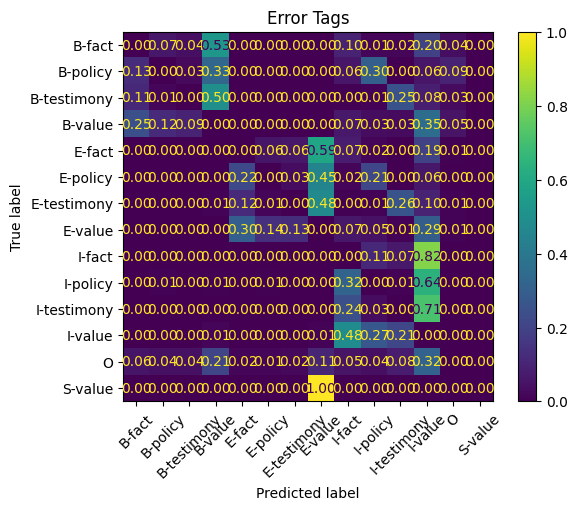

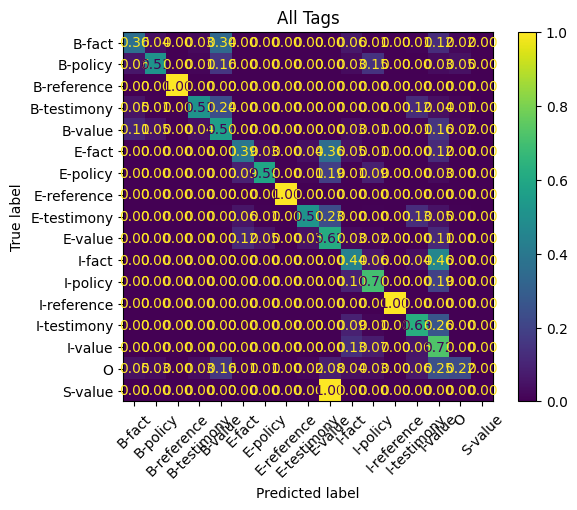

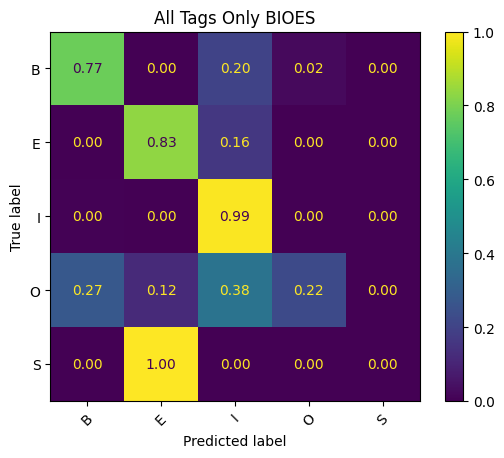

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score

def sk_f1(statistic):
    print(classification_report(statistic['TrueTag'], statistic['FixedInferedTag'], zero_division=0))
    return classification_report(statistic['TrueTag'], statistic['FixedInferedTag'], zero_division=0, output_dict=True)

def component_level_statistic(true_intervals, infered_intervals, rate):
    
    def fill_segments(intervals, fix_tags = False):
        b = []
        e = []
        s = []
        
        prev_e = True
        for i,tag in enumerate(intervals):
            bioes = tag[0]
            meta = tag[2:]
            if bioes == "B":
                
                if not prev_e and fix_tags:
                    print(f"WARNING: Fixing tag {tag} at {i}. Searching for Missing E tag.")
                    last_b, b_meta = b[-1]
                    for j, j_tag in enumerate(intervals[last_b+1:i+1], start=last_b+1):
                        if j_tag != f"I-{b_meta}":
                            e.append((j-1, b_meta))
                            break
                        elif j == len(intervals) - 1:
                            e.append((j, b_meta))
                            break
                    else:
                        raise Exception("No E tag candidate found")
                
                b.append((i, meta))
                prev_e = False
            elif bioes == "E":
                
                if prev_e and fix_tags:
                    print(f"WARNING: Fixing tag {tag} at {i}. Searching for Missing B tag.")
                    last_e, e_meta = e[-1]
                    for j, j_tag in enumerate(intervals[last_e+1:i], start=last_e+1):
                        j_tag_meta = j_tag[2:]
                        if j_tag[0] != "O":
                            b.append((j, j_tag_meta))
                            break
                    else:
                        raise Exception("No B tag candidate found")
                
                e.append((i, meta))
                prev_e = True
            elif bioes == "S":
                s.append((i, meta))
                
                prev_e = True
        
        assert len(b) == len(e), "Unbalanced B and E tags"
        
        intervals = sorted([(b, e + 1, t) for (b, t),(e, t) in zip(b,e)] + [(s, s + 1, t) for (s, t) in s])
        return intervals
    
    def compute_interval_complement(segments):
        false_segments = []
        last_end = 0
        for start, end, _ in segments:
            if last_end < start:
                false_segments.append((last_end, start, "O-NEGATIVE_CLASS"))
            last_end = end
        return false_segments
    
    true_segments = fill_segments(true_intervals, fix_tags=True) # The segment might be too long for the model
    false_segments = compute_interval_complement(true_segments)
    all_true_segments = sorted(true_segments+false_segments)

    
    pred_segments = fill_segments(infered_intervals)
    false_pred_segments = compute_interval_complement(pred_segments)
    all_pred_segments = sorted(pred_segments+false_pred_segments)

    
    def return_true_positive_and_false_negative(true_segments, pred_segments):
        true_positive = 0
        false_negative = 0
        intersections = []
        
        for current_true_start, current_true_end, current_true_tag in true_segments:
            top_match = 0
            top_interval = None
            length = current_true_end - current_true_start
            for current_pred_start, current_pred_end, current_pred_tag in pred_segments:
                current_match = 0
                if current_pred_end <= current_true_start or current_true_end <= current_pred_start:
                    current_match = 0
                else:
                    max_start = max(current_true_start, current_pred_start)
                    min_end = min(current_true_end, current_pred_end)
                    intersection_length = min_end - max_start
                    assert intersection_length > 0

                    if intersection_length/length >= rate and intersection_length > top_match and current_pred_tag == current_true_tag:
                        top_interval = min_end, max_start, current_pred_tag
                        top_match = intersection_length

            if top_interval is not None:
                true_positive += 1
            else:
                false_negative += 1
                    
        return true_positive, false_negative
    
    
    true_positive, false_negative = return_true_positive_and_false_negative(all_true_segments, all_pred_segments)
    _, false_positive = return_true_positive_and_false_negative(pred_segments, all_true_segments)
    
    try:
        precision = true_positive / (true_positive + false_positive)
    except:
        precision = 0
    try:
        recall = true_positive / (true_positive + false_negative)
    except:
        recall = 0
    try:
        f1 = 2 * (precision * recall) / (precision + recall)
    except:
        f1 = 0

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    
    return {"precision": precision, "recall": recall, "f1": f1, "rate": rate}
    
def plot_confusion_matrix(params, true_y, pred_y, title, xticks_rotation=0):
    ConfusionMatrixDisplay.from_predictions(true_y, pred_y, normalize="true", values_format=".2f")
    plt.xticks(rotation = xticks_rotation)
    plt.title(title)
    plt.savefig(Path(params['model_histories_path']) /  (title + ".png"))
    plt.show()


def show_statistic(params: dict):
    error_statistic, all_statistic = params['general_statistic']

    print()
    total_size = len(all_statistic)
    
    print()
    print("Tag Accuracy:", len(all_statistic[all_statistic["TrueTag"] == all_statistic["FixedInferedTag"]])/total_size)
    print("BIOES-only Accuracy:", len(all_statistic[all_statistic["TrueTag"].map(lambda x: x[0]) == all_statistic["FixedInferedTag"].map(lambda x: x[0])])/total_size)
    print()
    
    infered_fixed_errors = error_statistic[error_statistic["TrueTag"] != error_statistic["FixedInferedTag"]]
    bio_infered_fix_errors = error_statistic[error_statistic["TrueTag"].map(lambda x: x[0]) != error_statistic["FixedInferedTag"].map(lambda x: x[0])]
    
    headers = [
        ("Infered with Fixed Tags Error Rate", infered_fixed_errors),
        ("BIOES-only Infered with Fixed Tags Error Rate", bio_infered_fix_errors),
    ]
    for title, df in headers:
        print(title)
        print(len(df)/total_size)
        print()
    
    print("All tags statistic")
    all_f1_report = sk_f1(all_statistic)
    print()
    
    print("BIOES tags statistic")
    bio_statistic = all_statistic.applymap(lambda x: x[0] if len(x) > 0 else "")
    bioes_f1_report = sk_f1(bio_statistic)
    print()
    
    
    print("Component statistic 100%: ")
    all_100_report = component_level_statistic(all_statistic["TrueTag"], all_statistic["FixedInferedTag"], 1)
    print()
    print("Component statistic 50%: ")
    all_50_report = component_level_statistic(all_statistic["TrueTag"], all_statistic["FixedInferedTag"], .5)
    print()
    
    print("BIOES Component statistic 100%: ")
    bioes_100_report = component_level_statistic(bio_statistic["TrueTag"], bio_statistic["FixedInferedTag"], 1)
    print()
    print("BIOES Component statistic 50%: ")
    bioes_50_report = component_level_statistic(bio_statistic["TrueTag"], bio_statistic["FixedInferedTag"], .5)
    print()
    
    plot_confusion_matrix(params, error_statistic["TrueTag"], error_statistic["FixedInferedTag"], "Error Tags", xticks_rotation=45)
    plot_confusion_matrix(params, all_statistic["TrueTag"], all_statistic["FixedInferedTag"], "All Tags", xticks_rotation=45)
    plot_confusion_matrix(params, all_statistic["TrueTag"].map(lambda x: x[0]), all_statistic["FixedInferedTag"].map(lambda x: x[0]), "All Tags Only BIOES", xticks_rotation=45)

    statistic = {
        "all_report": all_f1_report,
        "bioes_report": bioes_f1_report,
        "all_100_component": all_100_report,
        "all_50_component": all_50_report,
        "bioes_100_component": bioes_100_report,
        "bioes_50_component": bioes_50_report,
        
    }
    
    with (Path(params['model_histories_path']) / "statistic.json").open('w') as f:
        json.dump(statistic, f)
        
show_statistic(params)


## Joint Metrics

Show the metrics for all models. The models should be in DATA_DIR.

paragraph_pos_model_cnn_lstm_blstm_resnet_norm_crf -> ppmclbrnc
paragraph_pos_model_cnn_lstm_blstm_resnet_norm_dn_lower_crf -> ppmclbrndlc


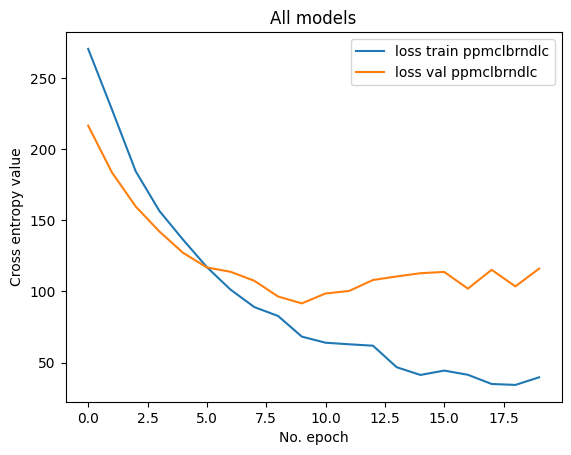

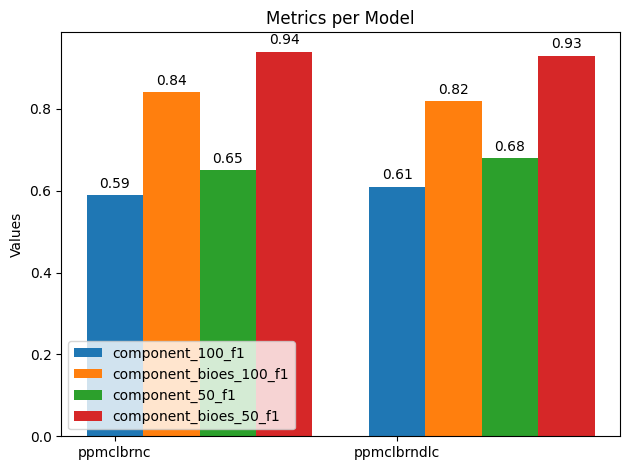

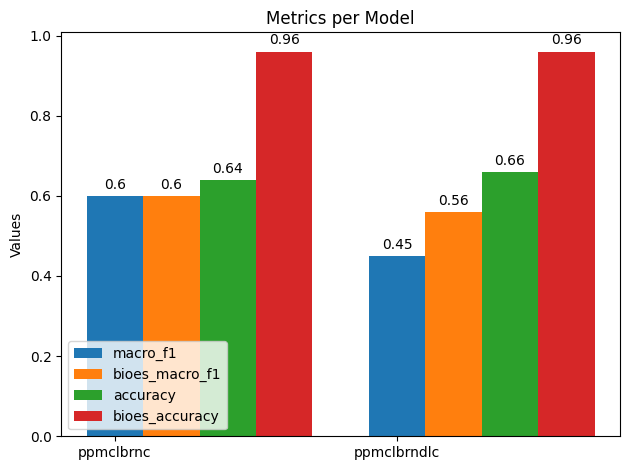

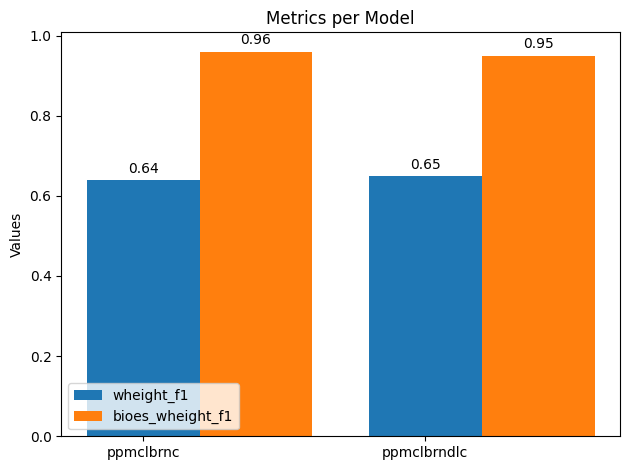

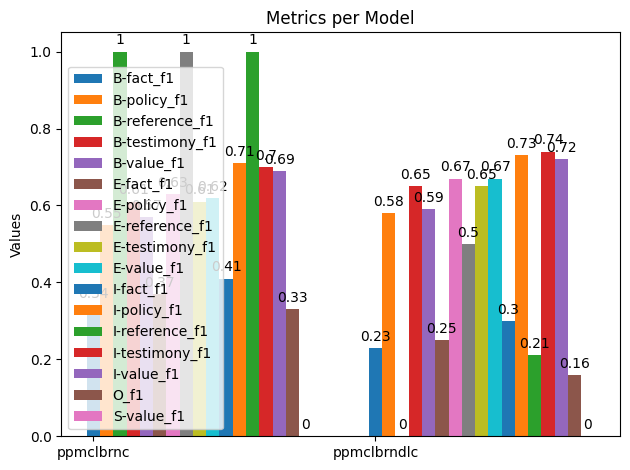

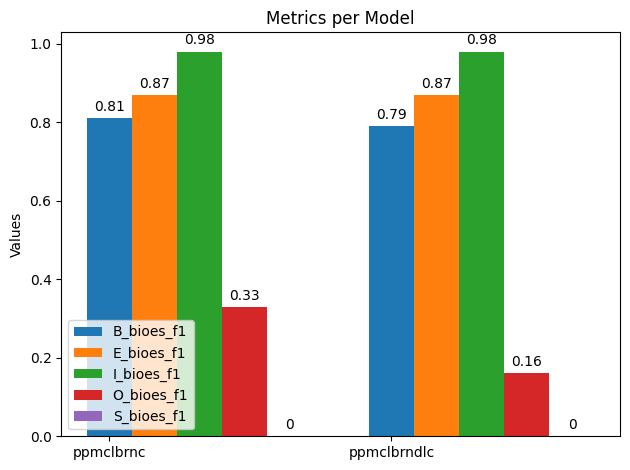

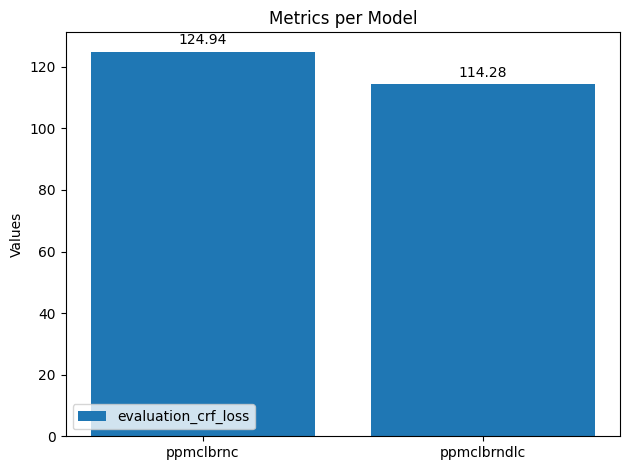

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def build_multiple_bar_plot(labels: list, values: dict, width=0.35, save: Path=None):

    x = np.arange(len(labels))  # the label locations

    fig, ax = plt.subplots()
    rects = []
    
    for i, label in enumerate(values):
        values_values = values[label]
        diff = width / len(values) 
        rect = ax.bar(x + diff * i, [round(x,2) for x in values_values], diff, label=label)
        rects.append(rect)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Values')
    ax.set_title('Metrics per Model')
    ax.set_xticks(x, labels, rotation=0)
    ax.legend(loc="lower left")

    for rect in rects:
        ax.bar_label(rect, padding=3)

    fig.tight_layout()

    if save:
        plt.savefig(save)
    
    plt.show()


def print_joint_metrics(params: dict):
    
    base_path = Path(params['data_path'])
    tags_path = Path(params['tags_path'])
    
    tags = sorted([x.strip() for x in tags_path.open().readlines()])
    bioes_tags = sorted(set(tag[0] for tag in tags))
    
    def plot_history(history, model_name):

        plt.plot(history['crf_loss'], label=f'loss train {model_name}')
        plt.plot(history['val_crf_loss'], label=f'loss val {model_name}')

    def show_plot():
        plt.title("All models")
        plt.ylabel('Cross entropy value')
        plt.xlabel('No. epoch')
#         plt.legend(loc="upper right")
        plt.legend()
        plt.savefig(base_path / "crf_loss.png")
        plt.show()
    
    statistic_df = {
        "model_name": [],
        "component_bioes_100_precision": [],
        "component_bioes_100_recall": [],
        "component_bioes_100_f1": [],
        "component_bioes_50_precision": [],
        "component_bioes_50_recall": [],
        "component_bioes_50_f1": [],
        "component_100_precision": [],
        "component_100_recall": [],
        "component_100_f1": [],
        "component_50_precision": [],
        "component_50_recall": [],
        "component_50_f1": [],
        **{f"{tag}_precision": [] for tag in tags},
        **{f"{tag}_recall": [] for tag in tags},
        **{f"{tag}_f1": [] for tag in tags},
        **{f"{tag}_bioes_precision": [] for tag in bioes_tags},
        **{f"{tag}_bioes_recall": [] for tag in bioes_tags},
        **{f"{tag}_bioes_f1": [] for tag in bioes_tags},
        "macro_f1": [],
        "wheight_f1": [],
        "accuracy": [],
        "bioes_macro_f1": [],
        "bioes_wheight_f1": [],
        "bioes_accuracy": [],
        "evaluation_crf_loss": []
        
    }
    
    name_map = {}
    
    for model_path in base_path.iterdir():
        if model_path.is_dir():
            model_name = model_path.name
            statistic_df["model_name"].append(model_name)
            smaller_name = "".join([x[0] for x in model_name.split("_")])
            name_map[model_name] = smaller_name
            
            history_path = model_path / f"history.json"
            if history_path.exists():
                print(f"WARNING: History for {model_name} not found" )
                history = json.load(history_path.open())
                plot_history(history, smaller_name)
            
            statistic = model_path / "statistic.json"
            statistic = json.load(statistic.open())
            to_remove = []
            for tag in tags:
                try:
                    statistic_df[f"{tag}_precision"].append(statistic["all_report"][tag]["precision"])
                    statistic_df[f"{tag}_recall"].append(statistic["all_report"][tag]["recall"])
                    statistic_df[f"{tag}_f1"].append(statistic["all_report"][tag]["f1-score"])
                except KeyError as e:
                    to_remove.append(tag)
                    pass
            for tag in to_remove:
                tags.remove(tag)
            
            evaluation_path = model_path / "evaluation.json"
            evaluation = json.load(evaluation_path.open())
            statistic_df["evaluation_crf_loss"].append(evaluation['crf_loss'])
            
            statistic_df["macro_f1"].append(statistic["all_report"]["macro avg"]["f1-score"])
            statistic_df["wheight_f1"].append(statistic["all_report"]["weighted avg"]["f1-score"])
            statistic_df["accuracy"].append(statistic["all_report"]["accuracy"])
            statistic_df["component_100_precision"].append(statistic['all_100_component']['precision'])
            statistic_df["component_100_recall"].append(statistic['all_100_component']['recall'])
            statistic_df["component_100_f1"].append(statistic['all_100_component']['f1'])
            statistic_df["component_50_precision"].append(statistic['all_50_component']['precision'])
            statistic_df["component_50_recall"].append(statistic['all_50_component']['recall'])
            statistic_df["component_50_f1"].append(statistic['all_50_component']['f1'])


            to_remove = []
            for tag in bioes_tags:
                try:
                    statistic_df[f"{tag}_bioes_precision"].append(statistic["bioes_report"][tag]["precision"])
                    statistic_df[f"{tag}_bioes_recall"].append(statistic["bioes_report"][tag]["recall"])
                    statistic_df[f"{tag}_bioes_f1"].append(statistic["bioes_report"][tag]["f1-score"])
                except KeyError as e:
                    to_remove.append(tag)
                    pass
            for tag in to_remove:
                bioes_tags.remove(tag)
            
            statistic_df["bioes_macro_f1"].append(statistic["bioes_report"]["macro avg"]["f1-score"])
            statistic_df["bioes_wheight_f1"].append(statistic["bioes_report"]["weighted avg"]["f1-score"])
            statistic_df["bioes_accuracy"].append(statistic["bioes_report"]["accuracy"])
            statistic_df["component_bioes_100_precision"].append(statistic['bioes_100_component']['precision'])
            statistic_df["component_bioes_100_recall"].append(statistic['bioes_100_component']['recall'])
            statistic_df["component_bioes_100_f1"].append(statistic['bioes_100_component']['f1'])
            statistic_df["component_bioes_50_precision"].append(statistic['bioes_50_component']['precision'])
            statistic_df["component_bioes_50_recall"].append(statistic['bioes_50_component']['recall'])
            statistic_df["component_bioes_50_f1"].append(statistic['bioes_50_component']['f1'])

                
    for key, value in name_map.items():
        print(key, "->", value)
    names_mapped = [name_map[name] for name in name_map]
    
    # Show train/loss 
    show_plot()
    
    
    keys = [
        "component_100_f1", 
        "component_bioes_100_f1", 
        "component_50_f1",
        "component_bioes_50_f1", 
    ]
    save = base_path / "components.png"
    build_multiple_bar_plot(names_mapped, {key: statistic_df[key] for key in keys}, width=0.8, save=save)
    
    keys = [
        "macro_f1", 
        "bioes_macro_f1", 
        "accuracy", 
        "bioes_accuracy",
    ]
    save = base_path / "macro_micro_metrics.png"
    build_multiple_bar_plot(names_mapped, {key: statistic_df[key] for key in keys}, width=0.8, save=save)
    
    keys = [
        "wheight_f1", 
        "bioes_wheight_f1", 
    ]
    save = base_path / "weight_macro_metrics.png"
    build_multiple_bar_plot(names_mapped, {key: statistic_df[key] for key in keys}, width=0.8, save=save)
    
    keys = [f"{tag}_f1" for tag in tags]
    save = base_path / "tags_f1.png"
    build_multiple_bar_plot(names_mapped, {key: statistic_df[key] for key in keys}, width=0.8, save=save)
    
    keys = [f"{tag}_bioes_f1" for tag in bioes_tags]
    save = base_path / "tags_bioes_f1.png"
    build_multiple_bar_plot(names_mapped, {key: statistic_df[key] for key in keys}, width=0.8, save=save)
    
    keys = [f"evaluation_crf_loss"]
    save = base_path / "evaluation.png"
    build_multiple_bar_plot(names_mapped, {key: statistic_df[key] for key in keys}, width=0.8, save=save)
    
print_joint_metrics(params)

## Using the Model

Perform the segmentation on text. The data to process directory must contain folders with **.txt** files, the tokens in this files must be separated by whitepaces. This files will be passed through the model and the output will be written in conll format in the processed directory.

In [ ]:
def load_and_build_model_from_params(params: dict):
    
    add_datasets(params)
    load_saved_model(params, 'model_path', params['model_name'])    
    encode_datasets(params)
    fixed_tags_model(params)
    return params["full_fixed_model"]

load_and_build_model_from_params(params)

In [ ]:
def train_pipeline(params: dict):
    create_segmenter_corpus(params)
    add_datasets(params)
    add_embeddings(params)
    create_model(params)
    encode_datasets(params)
    train_and_save_model(params)


In [ ]:
import os

def perform_segmentation(params: dict):
    model = params['full_fixed_model']
    batch_size = params['batch_size']
    to_process_path = params['to_process_data_path']
    to_save_path = params['processed_data_path']
    
    labels = sorted(list(os.walk(to_process_path))[0][1])
    print(labels)
    files = keras.utils.text_dataset_from_directory(
        str(to_process_path), 
        class_names = labels,
        shuffle = False,
    )
    
    base_path = Path(to_save_path) / params['model_name']
    base_path.mkdir(exist_ok=True, parents=True)
    
    file_number = 0
    filenames = [file.name for file in Path(to_process_path).rglob('*.txt')]
    
    for text_batch, label_batch in files:
        tag_batch = model(text_batch)
        for text, label, tags in zip(text_batch, label_batch, tag_batch):
            text = text.numpy().decode().split()
            tags = [tag for tag in tags]
            
            current_file = base_path / labels[label]
            current_file.mkdir(exist_ok=True)
            current_file /= filenames[file_number] + ".conll"
            current_file.touch()
            current_file.write_text("\n".join(f"{word}\t{tag}" for word,tag in zip(text, tags)))
            file_number += 1
            

perform_segmentation(params)

## Export jupyter as module

In [ ]:
if __name__ == "__main__":
    from pathlib import Path
    try:
        if Path(__file__).suffix == ".ipynb":
            raise NameError()
    except NameError:
        # In Jupyer Notebook
        from utils.notebook_utils import export_notebook_as_module
        export_notebook_as_module(Path("segmenter.ipynb"))